## benchmarking on sushmita ROY's dataset


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, unnormalize
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np
import joblib

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  IntOrKey = Union[int, jax.random.KeyArray]


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_utils.py:40: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def validate_seed(seed: IntOrKey) -> jax.random.KeyArray:


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_kmeans.py:21: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def _initialize_random(X: jnp.ndarray, n_clusters: int, key: jax.random.KeyArray) -> jnp.ndarray:


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_kmeans.py:31: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def _initialize_plus_plus(X: jnp.ndarray, n_clusters: int, key: jax.random.KeyArray) -> jnp.ndarray:


In [2]:
# '../../data/main/gene_embeddings.parquet')
MAXGENES = 5000
MAXCELLS = 1024
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None, )#organisms=['NCBITaxon:9606','NCBITaxon:10090'])
metrics = {}


RuntimeError caught: scPrint is not attached to a `Trainer`.

In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,do_postp=False, min_valid_genes_id=MAXGENES, min_dataset_size=64)

# han / human

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers: 

KeysView(Layers with keys: )

checking raw counts

removed 0 non primary cells, 5520 renamining

filtered out 0 cells, 5520 renamining

Removed 0 genes.

startin QC

Seeing 151 outliers (2.74% of total dataset):

done

(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295

/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [6]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision: 

0.038948387096774194


recall: 

1.0


random precision:

0.03895617833244068


  0%|                                         | 0/128 [00:00<?, ?it/s]


 62%|███████████████████▍           | 80/128 [00:00<00:00, 797.24it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████████████████████| 128/128 [00:00<00:00, 847.43it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0695345532881509

EPR:

2.978185129033612

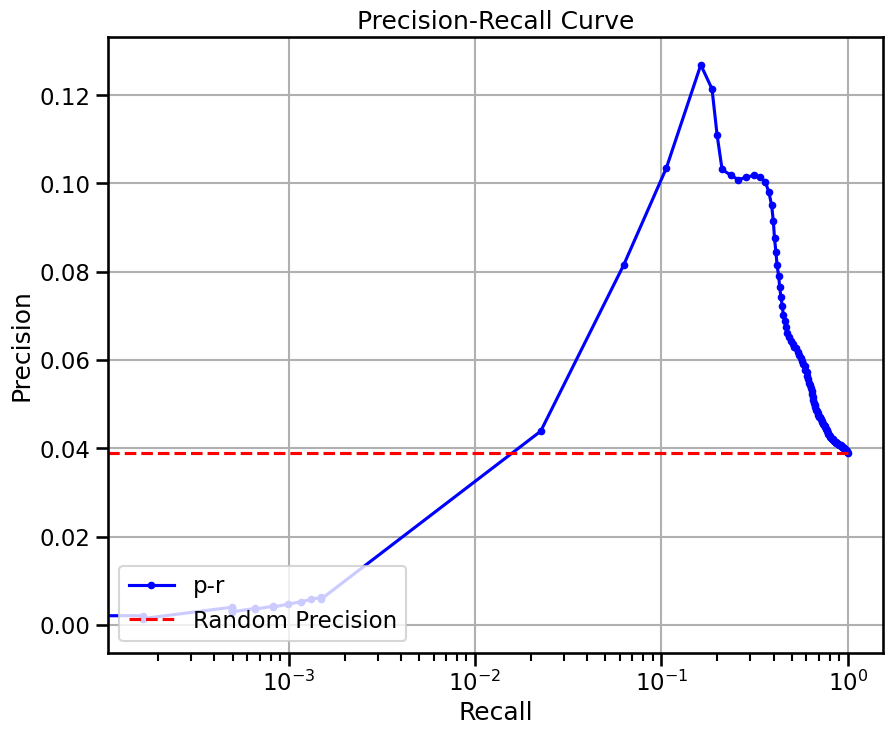

In [7]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment

Top central genes:

[]

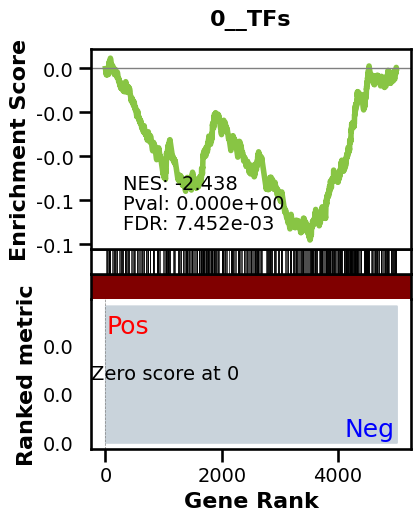

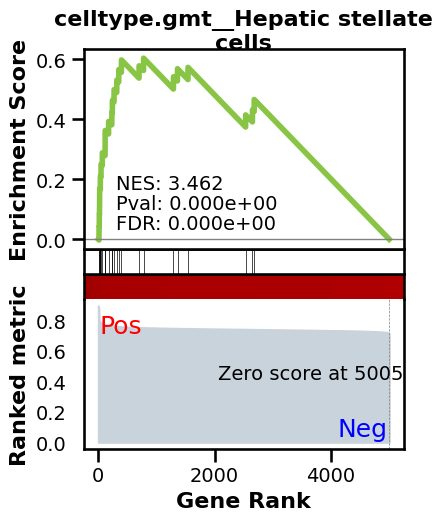

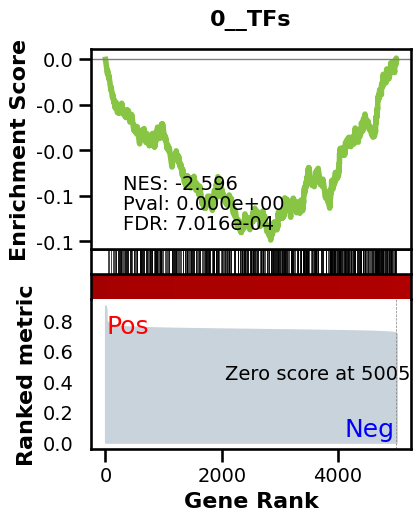

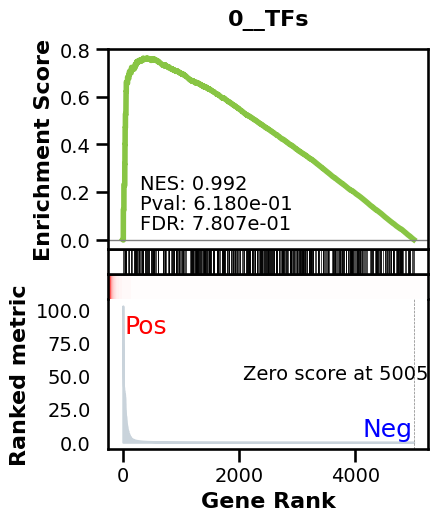

_________________________________________

TF specific enrichment

found some significant results for 

25.454545454545453

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 3767 genes

intersection pct:

0.7524970035956852

precision: 

0.0016151890916386552


recall: 

1.0


random precision:

0.001615617978811156


  0%|                                             | 0/128 [00:00<?, ?it/s]


  4%|█▍                                   | 5/128 [00:00<00:02, 43.80it/s]


  8%|██▊                                 | 10/128 [00:00<00:02, 43.76it/s]


 12%|████▏                               | 15/128 [00:00<00:02, 43.05it/s]


 16%|█████▋                              | 20/128 [00:00<00:02, 42.37it/s]


 20%|███████                             | 25/128 [00:00<00:02, 41.97it/s]


 23%|████████▍                           | 30/128 [00:00<00:02, 41.88it/s]


 27%|█████████▊                          | 35/128 [00:00<00:02, 41.95it/s]


 31%|███████████▎                        | 40/128 [00:00<00:02, 42.56it/s]


 35%|████████████▋                       | 45/128 [00:01<00:01, 42.84it/s]


 39%|██████████████                      | 50/128 [00:01<00:01, 42.46it/s]


 43%|███████████████▍                    | 55/128 [00:01<00:01, 41.54it/s]


 47%|████████████████▉                   | 60/128 [00:01<00:01, 41.40it/s]


 51%|██████████████████▎                 | 65/128 [00:01<00:01, 41.08it/s]


 55%|███████████████████▋                | 70/128 [00:01<00:01, 40.60it/s]


 59%|█████████████████████               | 75/128 [00:01<00:01, 40.19it/s]


 62%|██████████████████████▌             | 80/128 [00:01<00:01, 39.27it/s]


 66%|███████████████████████▋            | 84/128 [00:02<00:01, 38.75it/s]


 70%|█████████████████████████           | 89/128 [00:02<00:00, 39.26it/s]


 73%|██████████████████████████▍         | 94/128 [00:02<00:00, 39.96it/s]


 77%|███████████████████████████▊        | 99/128 [00:02<00:00, 40.21it/s]


 81%|████████████████████████████▍      | 104/128 [00:02<00:00, 37.22it/s]


 84%|█████████████████████████████▌     | 108/128 [00:02<00:00, 35.65it/s]


 88%|██████████████████████████████▉    | 113/128 [00:02<00:00, 37.78it/s]


 92%|████████████████████████████████▎  | 118/128 [00:02<00:00, 39.22it/s]


 95%|█████████████████████████████████▎ | 122/128 [00:03<00:00, 39.21it/s]


 99%|██████████████████████████████████▋| 127/128 [00:03<00:00, 40.47it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|███████████████████████████████████| 128/128 [00:03<00:00, 40.40it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.001805727737594386

EPR:

2.0321305173018605

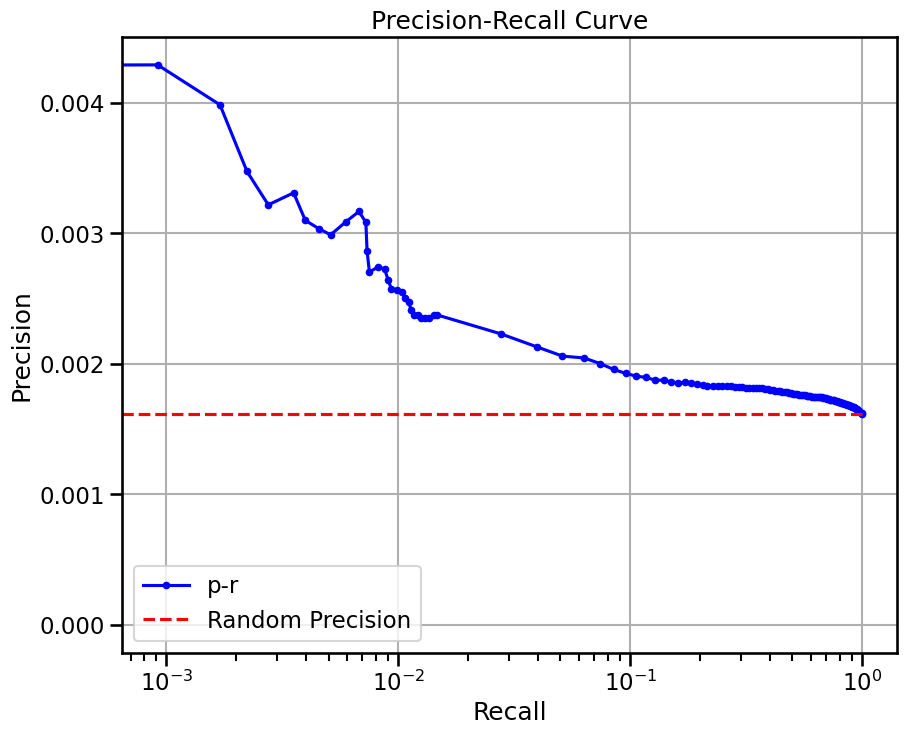

In [8]:
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_mean_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision: 

0.264192


recall: 

1.0


random precision:

0.26424484896979394


  0%|                                             | 0/128 [00:00<?, ?it/s]


 30%|██████████▋                        | 39/128 [00:00<00:00, 383.29it/s]


 71%|████████████████████████▉          | 91/128 [00:00<00:00, 458.99it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████████████████████████| 128/128 [00:00<00:00, 458.02it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.2946465490902279

EPR:

1.1545093654468563

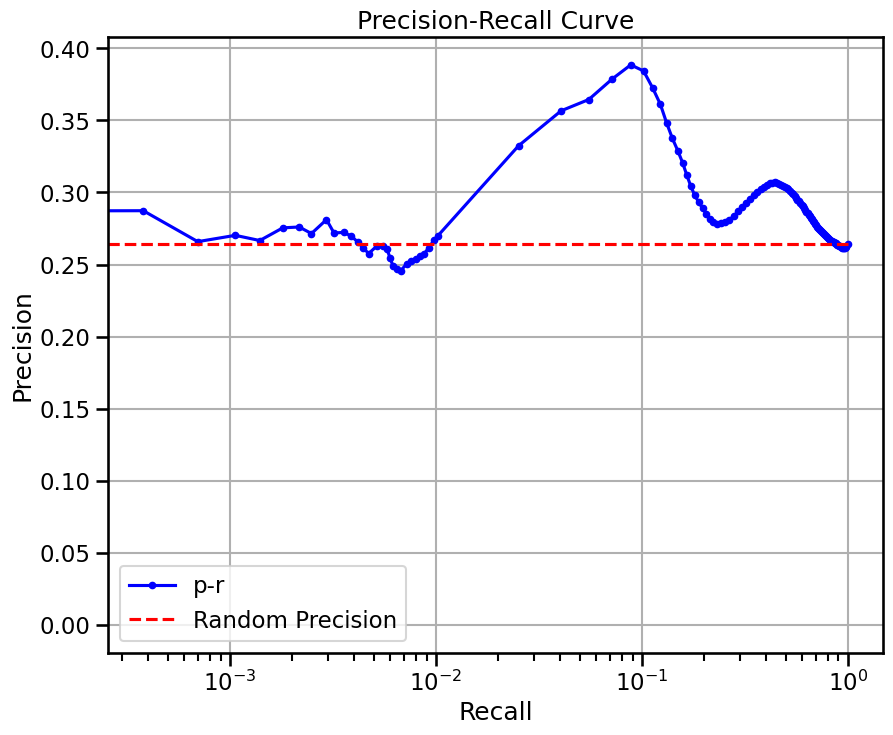

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_mean_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.08270819672131148


recall: 

1.0


random precision:

0.0827247416696454


  0%|                                             | 0/128 [00:00<?, ?it/s]


 29%|██████████                         | 37/128 [00:00<00:00, 366.82it/s]


 61%|█████████████████████▎             | 78/128 [00:00<00:00, 389.54it/s]


 93%|███████████████████████████████▌  | 119/128 [00:00<00:00, 395.77it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████████████████████████| 128/128 [00:00<00:00, 389.64it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.09642713636120592

EPR:

1.9393293614430762

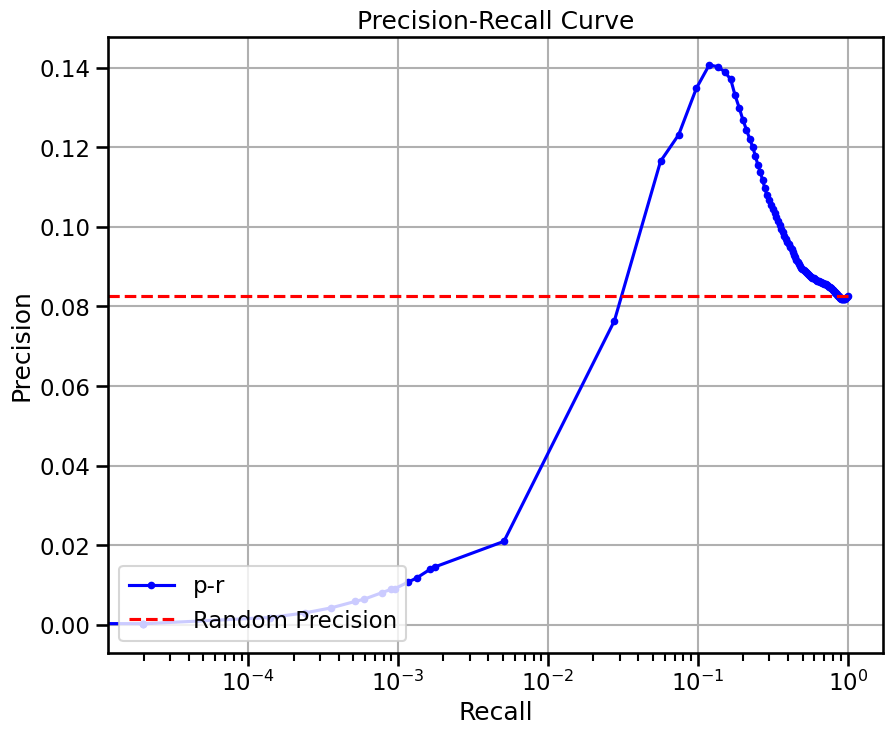

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_mean_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [11]:
preadata = get_sroy_gt(get="han", species="human", gt="full")

true elem

22920

...

doing classification....

metrics

{'used_heads': 101, 'precision': 0.005585292064230859, 'random_precision': 0.00165958553348804, 'recall': 0.01019108280254777, 'predicted_true': 4297.0, 'number_of_true': 2355.0, 'epr': 3.874463072539996}

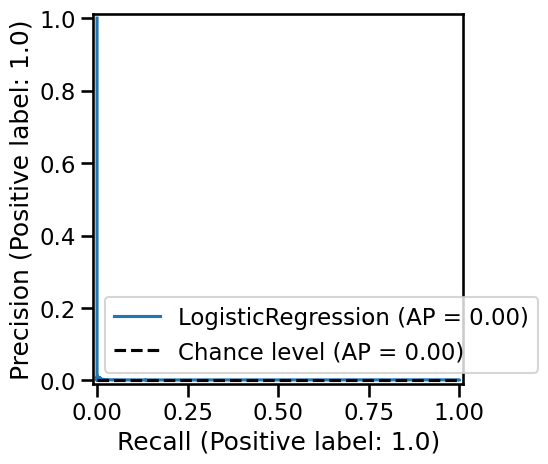

In [12]:
grn.varp["GRN"] = grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={1: 200, 0: 1}, shuffle=True)

In [13]:
# Save the clf_omni classifier to a file
joblib.dump(clf_omni, 'clf_omni_model.pkl')

['clf_omni_model.pkl']

precision: 

0.038948387096774194


recall: 

1.0


random precision:

0.03895617833244068


  0%|                         | 0/128 [00:00<?, ?it/s]


 58%|████████▋      | 74/128 [00:00<00:00, 735.72it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 826.14it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.05102900778280842

EPR:

4.779300230434627

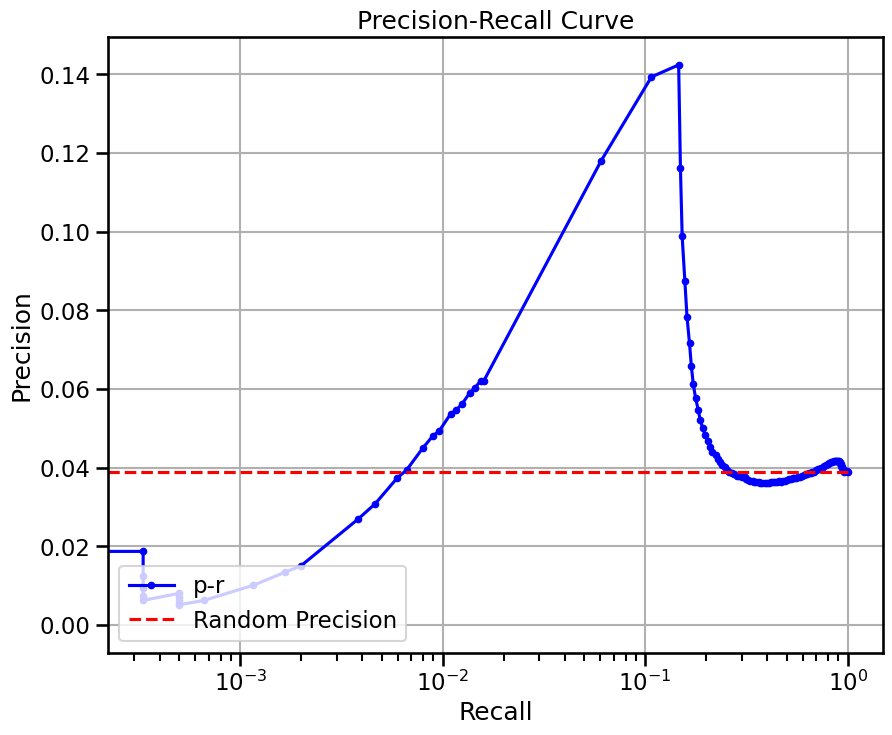

In [14]:
grn.varp['GRN'] = grn.varp['classified'].T
metrics['scprint_omni_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment

Top central genes:

[]

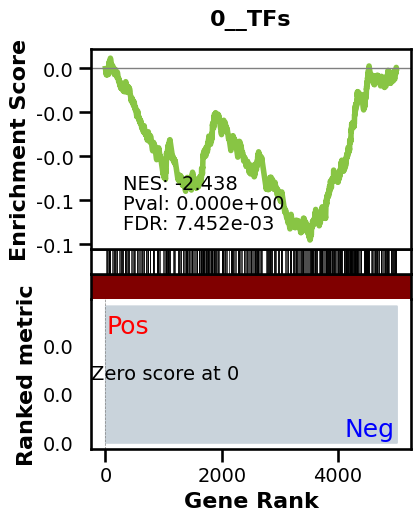

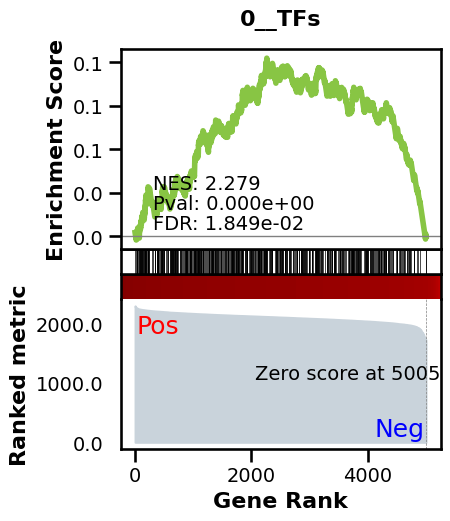

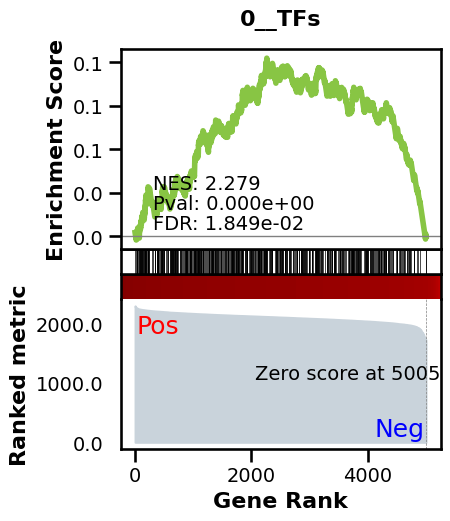

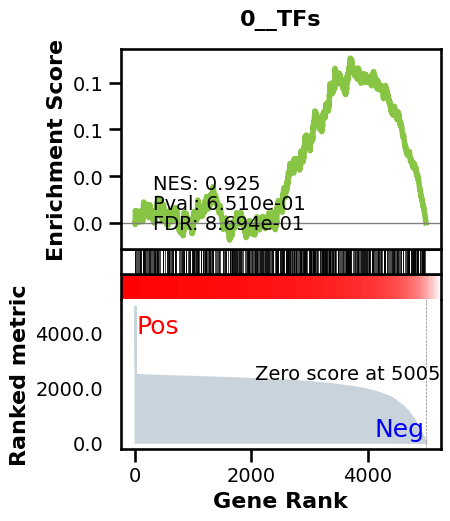

_________________________________________

TF specific enrichment

found some significant results for 

3.6363636363636362

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 3767 genes

intersection pct:

0.7524970035956852

precision: 

0.0016151890916386552


recall: 

1.0


random precision:

0.001615617978811156


  0%|                         | 0/128 [00:00<?, ?it/s]


  3%|▌                | 4/128 [00:00<00:03, 38.34it/s]


  6%|█                | 8/128 [00:00<00:03, 38.67it/s]


  9%|█▌              | 12/128 [00:00<00:03, 38.58it/s]


 12%|██              | 16/128 [00:00<00:02, 38.58it/s]


 16%|██▌             | 20/128 [00:00<00:02, 38.52it/s]


 19%|███             | 24/128 [00:00<00:02, 38.69it/s]


 22%|███▌            | 28/128 [00:00<00:02, 38.84it/s]


 25%|████            | 32/128 [00:00<00:02, 38.74it/s]


 28%|████▌           | 36/128 [00:00<00:02, 38.78it/s]


 31%|█████           | 40/128 [00:01<00:02, 38.67it/s]


 34%|█████▌          | 44/128 [00:01<00:02, 38.63it/s]


 38%|██████          | 48/128 [00:01<00:02, 38.65it/s]


 41%|██████▌         | 52/128 [00:01<00:01, 38.71it/s]


 44%|███████         | 56/128 [00:01<00:01, 38.64it/s]


 47%|███████▌        | 60/128 [00:01<00:01, 38.08it/s]


 50%|████████        | 64/128 [00:01<00:01, 37.46it/s]


 53%|████████▌       | 68/128 [00:01<00:01, 37.25it/s]


 56%|█████████       | 72/128 [00:01<00:01, 37.02it/s]


 59%|█████████▌      | 76/128 [00:01<00:01, 37.17it/s]


 62%|██████████      | 80/128 [00:02<00:01, 37.55it/s]


 66%|██████████▌     | 84/128 [00:02<00:01, 37.96it/s]


 69%|███████████     | 88/128 [00:02<00:01, 38.27it/s]


 72%|███████████▌    | 92/128 [00:02<00:00, 38.41it/s]


 75%|████████████    | 96/128 [00:02<00:00, 38.62it/s]


 78%|███████████▋   | 100/128 [00:02<00:00, 38.59it/s]


 81%|████████████▏  | 104/128 [00:02<00:00, 38.44it/s]


 84%|████████████▋  | 108/128 [00:02<00:00, 37.97it/s]


 88%|█████████████▏ | 112/128 [00:02<00:00, 38.14it/s]


 91%|█████████████▌ | 116/128 [00:03<00:00, 38.33it/s]


 94%|██████████████ | 120/128 [00:03<00:00, 36.94it/s]


 97%|██████████████▌| 124/128 [00:03<00:00, 37.30it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|███████████████| 128/128 [00:03<00:00, 37.44it/s]


100%|███████████████| 128/128 [00:03<00:00, 38.08it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0016597323147233773

EPR:

5.144683761135769

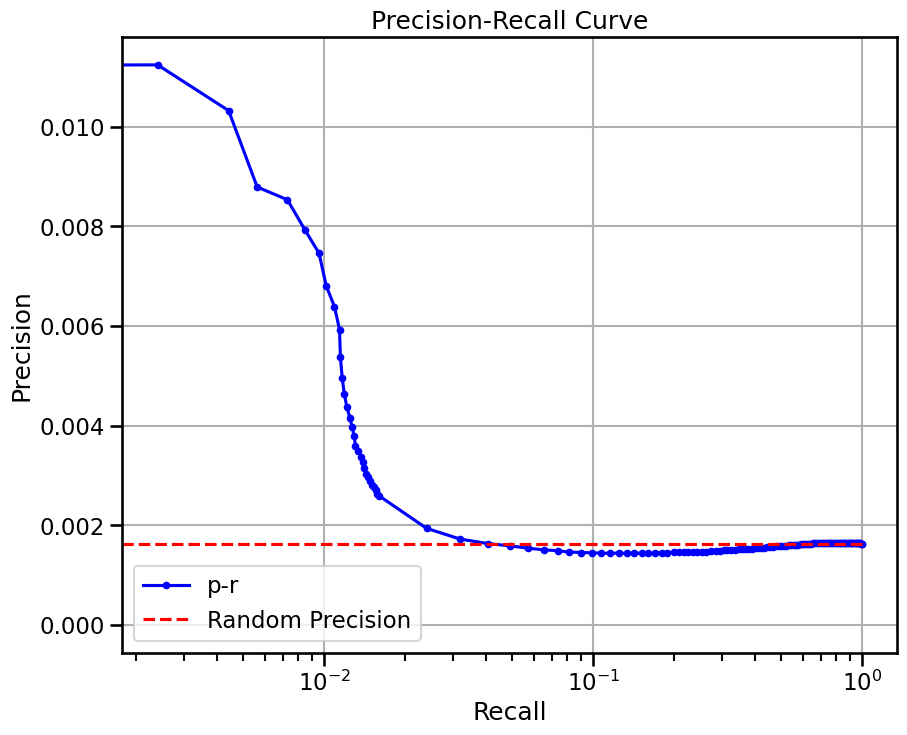

In [15]:
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_omni_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision: 

0.264192


recall: 

1.0


random precision:

0.26424484896979394


  0%|                         | 0/128 [00:00<?, ?it/s]


 25%|███▊           | 32/128 [00:00<00:00, 318.85it/s]


 63%|█████████▍     | 81/128 [00:00<00:00, 417.03it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 427.10it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.2443474123691465

EPR:

0.7666396099600191

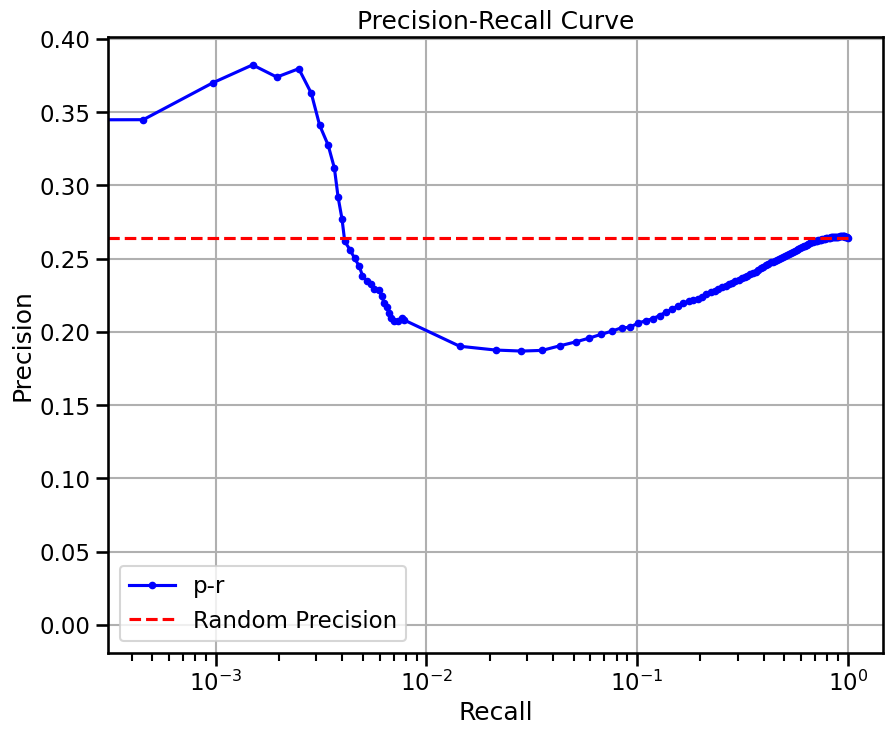

In [16]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_omni_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.08270819672131148


recall: 

1.0


random precision:

0.0827247416696454


  0%|                         | 0/128 [00:00<?, ?it/s]


 27%|████           | 35/128 [00:00<00:00, 342.89it/s]


 58%|████████▋      | 74/128 [00:00<00:00, 366.30it/s]


 88%|████████████▎ | 113/128 [00:00<00:00, 375.37it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 369.73it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.07761447938604331

EPR:

0.7330050915595431

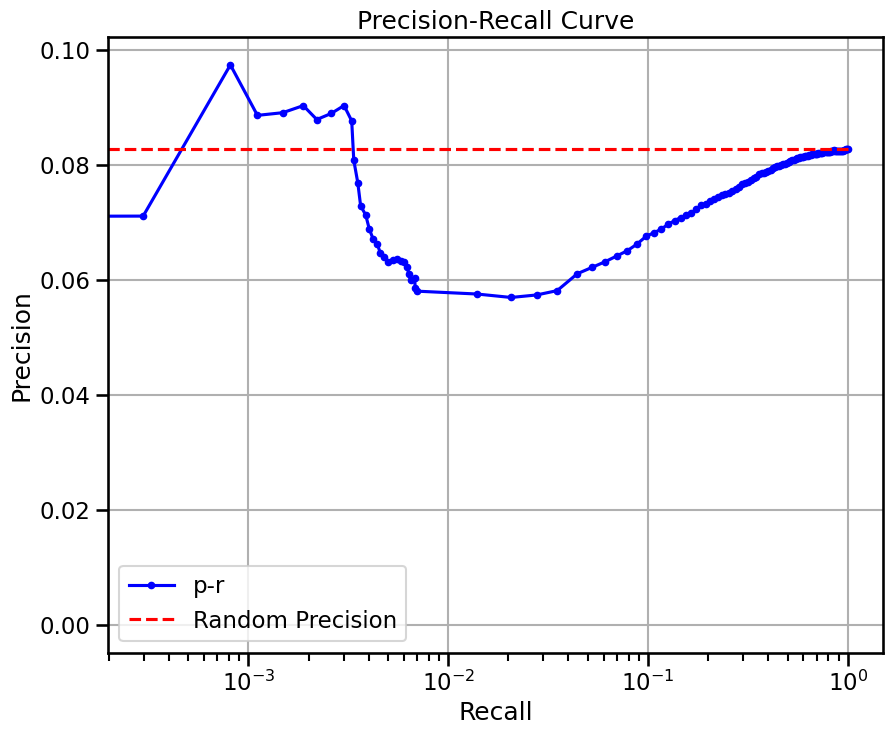

In [17]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_omni_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape

(122, 5000, 128)

true elem

50452

...

doing classification....

metrics

{'used_heads': 20, 'precision': 0.10584965520857914, 'random_precision': 0.08208196721311475, 'recall': 0.8062712202915918, 'predicted_true': 190695.0, 'number_of_true': 25035.0, 'epr': 3.9168286337960083}

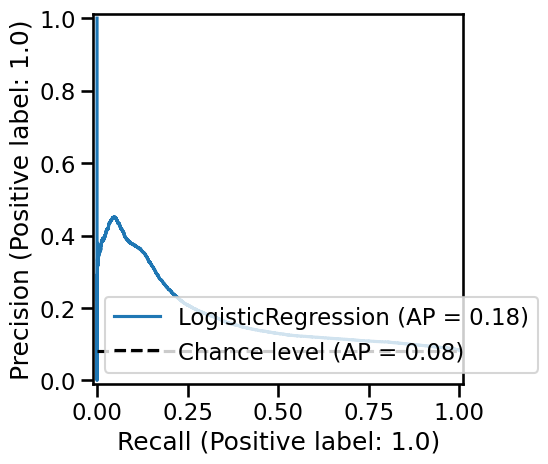

precision: 

0.08270819672131148


recall: 

1.0


random precision:

0.0827247416696454


  0%|                         | 0/128 [00:00<?, ?it/s]


 11%|█▋             | 14/128 [00:00<00:00, 138.35it/s]


 27%|███▉           | 34/128 [00:00<00:00, 170.32it/s]


 42%|██████▎        | 54/128 [00:00<00:00, 181.75it/s]


 58%|████████▋      | 74/128 [00:00<00:00, 187.73it/s]


 73%|███████████    | 94/128 [00:00<00:00, 190.78it/s]


 89%|████████████▍ | 114/128 [00:00<00:00, 192.72it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 185.61it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.175330248860198

EPR:

3.785081109470365

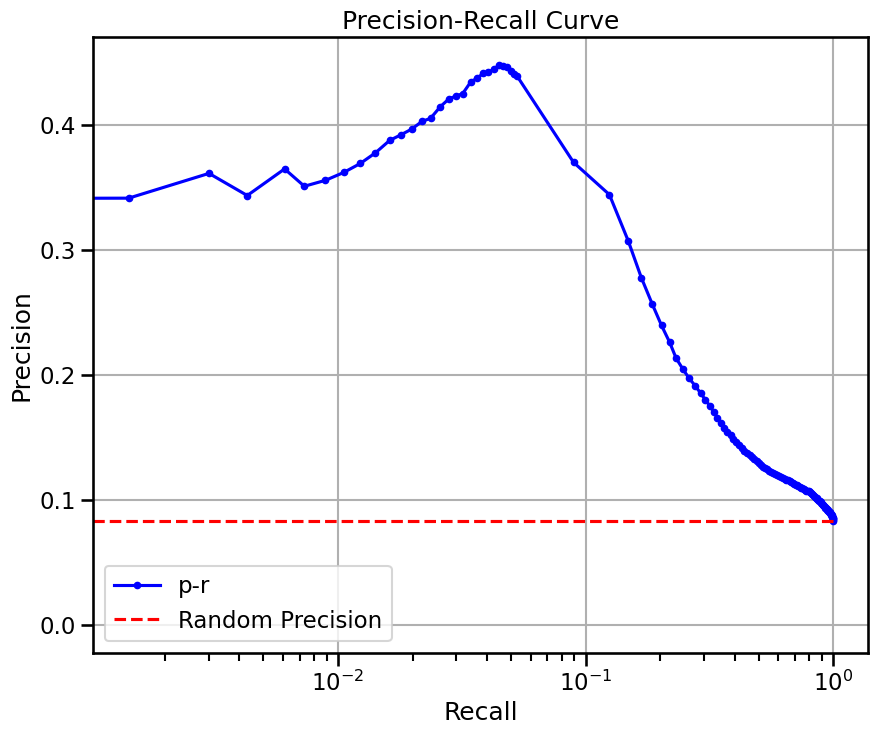

In [18]:
grn.varp['GRN'] = np.transpose(grn.varp['all'], (1,0,2))
weight = int((preadata.grn.sum(1)>0).sum()* (preadata.grn.sum(0)>0).sum()/ preadata.grn.sum().sum())
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.5, class_weight={1: weight, 0: 1}, shuffle=True, max_iter=500,)
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_self_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [19]:
joblib.dump(clf_self, 'clf_self_model.pkl')

['clf_self_model.pkl']

base enrichment

Top central genes:

[]

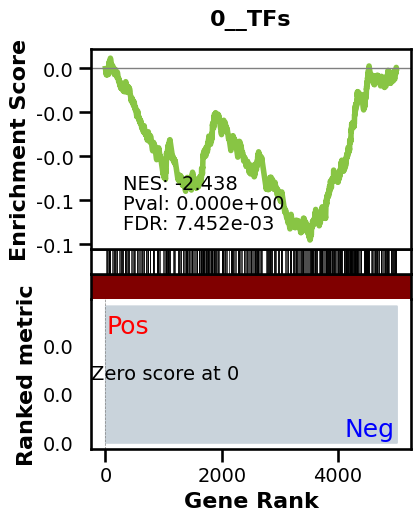

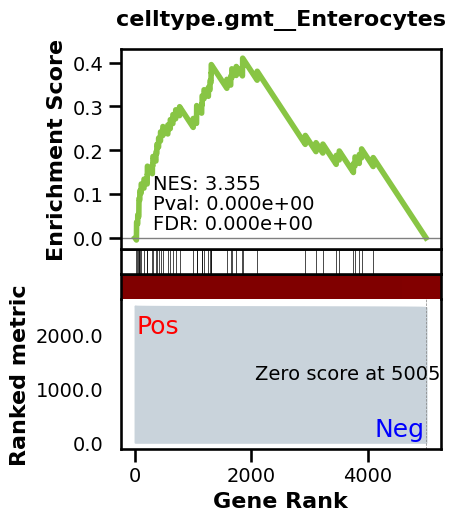

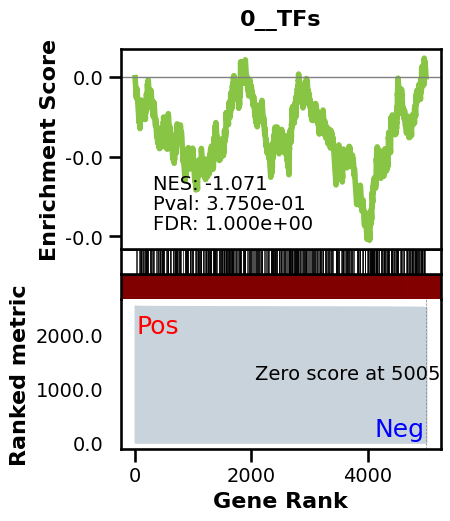

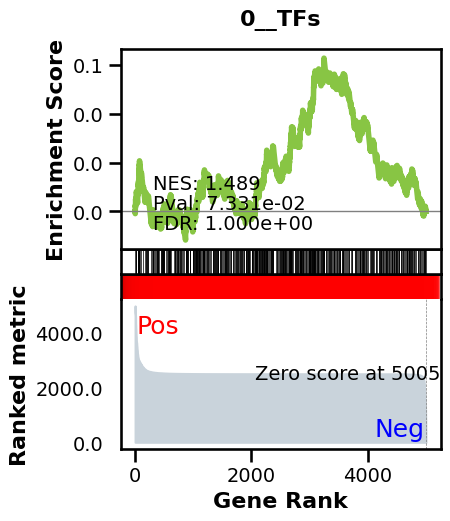

_________________________________________

TF specific enrichment

found some significant results for 

12.727272727272727

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 3767 genes

intersection pct:

0.7524970035956852

precision: 

0.0016151890916386552


recall: 

1.0


random precision:

0.001615617978811156


  0%|                         | 0/128 [00:00<?, ?it/s]


  3%|▌                | 4/128 [00:00<00:03, 37.42it/s]


  6%|█                | 8/128 [00:00<00:03, 37.56it/s]


  9%|█▌              | 12/128 [00:00<00:03, 37.32it/s]


 12%|██              | 16/128 [00:00<00:03, 36.98it/s]


 16%|██▌             | 20/128 [00:00<00:02, 37.12it/s]


 19%|███             | 24/128 [00:00<00:02, 37.38it/s]


 22%|███▌            | 28/128 [00:00<00:02, 37.59it/s]


 25%|████            | 32/128 [00:00<00:02, 37.50it/s]


 28%|████▌           | 36/128 [00:00<00:02, 37.65it/s]


 31%|█████           | 40/128 [00:01<00:02, 37.71it/s]


 34%|█████▌          | 44/128 [00:01<00:02, 37.77it/s]


 38%|██████          | 48/128 [00:01<00:02, 37.79it/s]


 41%|██████▌         | 52/128 [00:01<00:02, 37.63it/s]


 44%|███████         | 56/128 [00:01<00:01, 37.33it/s]


 47%|███████▌        | 60/128 [00:01<00:01, 37.37it/s]


 50%|████████        | 64/128 [00:01<00:01, 37.48it/s]


 53%|████████▌       | 68/128 [00:01<00:01, 37.51it/s]


 56%|█████████       | 72/128 [00:01<00:01, 37.63it/s]


 59%|█████████▌      | 76/128 [00:02<00:01, 37.57it/s]


 62%|██████████      | 80/128 [00:02<00:01, 37.57it/s]


 66%|██████████▌     | 84/128 [00:02<00:01, 37.63it/s]


 69%|███████████     | 88/128 [00:02<00:01, 37.65it/s]


 72%|███████████▌    | 92/128 [00:02<00:00, 37.66it/s]


 75%|████████████    | 96/128 [00:02<00:00, 37.75it/s]


 78%|███████████▋   | 100/128 [00:02<00:00, 37.78it/s]


 81%|████████████▏  | 104/128 [00:02<00:00, 37.79it/s]


 84%|████████████▋  | 108/128 [00:02<00:00, 37.65it/s]


 88%|█████████████▏ | 112/128 [00:02<00:00, 37.59it/s]


 91%|█████████████▌ | 116/128 [00:03<00:00, 35.39it/s]


 94%|██████████████ | 120/128 [00:03<00:00, 35.56it/s]


 97%|██████████████▌| 124/128 [00:03<00:00, 35.50it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|███████████████| 128/128 [00:03<00:00, 35.06it/s]


100%|███████████████| 128/128 [00:03<00:00, 37.06it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0015919474382696886

EPR:

0.9450126925343056

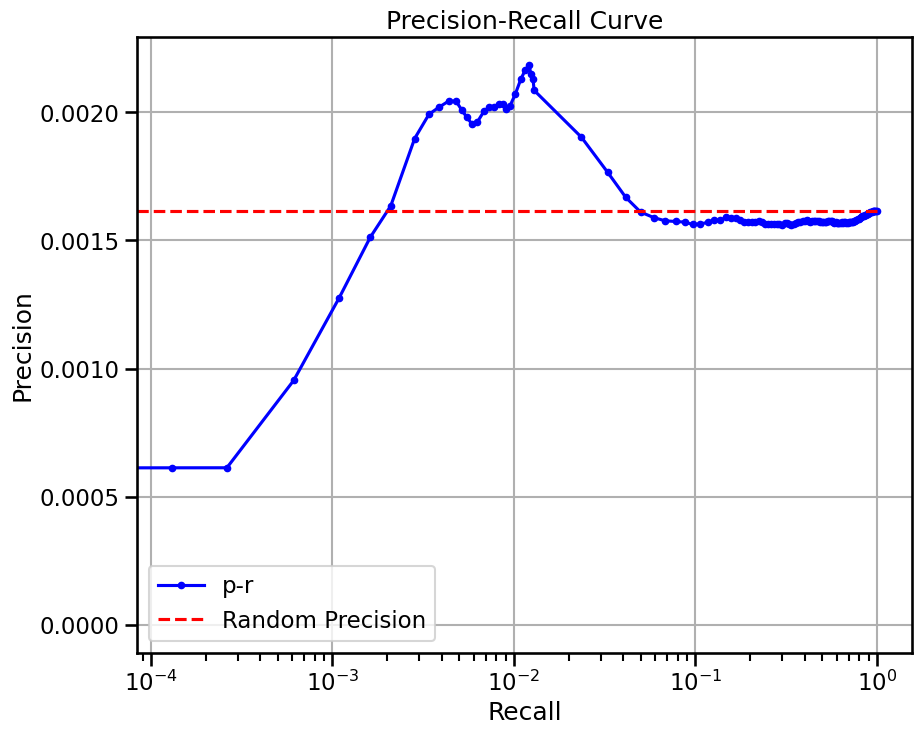

In [20]:
grn.varp['GRN'] = grn.varp['classified'].T
metrics['scprint_self_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision: 

0.264192


recall: 

1.0


random precision:

0.26424484896979394


  0%|                         | 0/128 [00:00<?, ?it/s]


 25%|███▊           | 32/128 [00:00<00:00, 313.79it/s]


 63%|█████████▍     | 81/128 [00:00<00:00, 412.85it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 424.95it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.26014642237807273

EPR:

0.9228280908516894

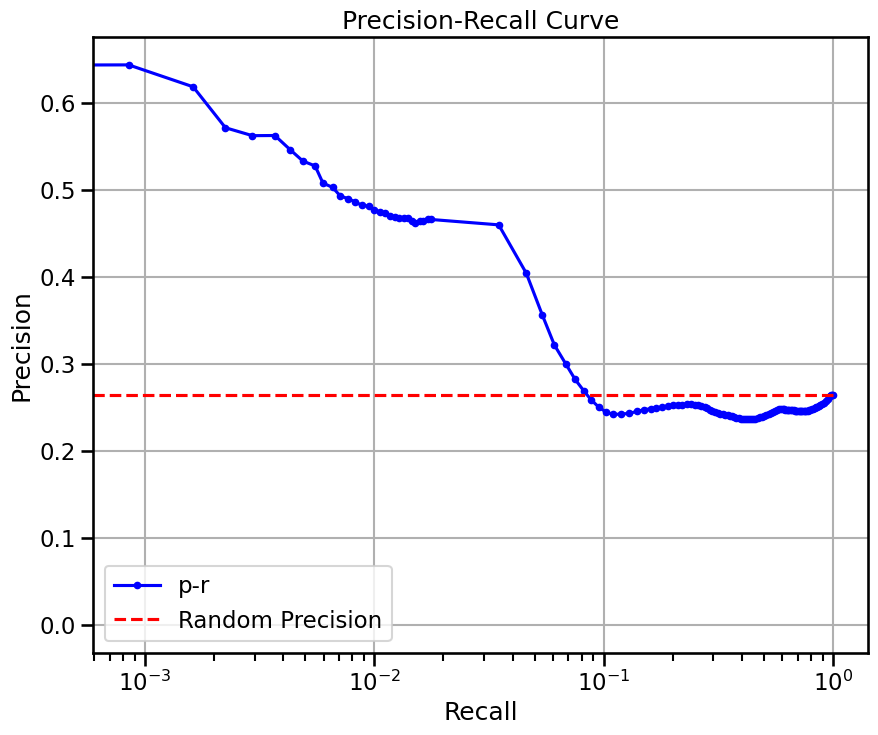

In [21]:
grn.varp['GRN'] = grn.varp['classified']
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_self_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.08270819672131148


recall: 

1.0


random precision:

0.0827247416696454


  0%|                         | 0/128 [00:00<?, ?it/s]


 25%|███▊           | 32/128 [00:00<00:00, 315.49it/s]


 52%|███████▊       | 67/128 [00:00<00:00, 334.43it/s]


 80%|███████████▎  | 103/128 [00:00<00:00, 343.86it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 341.65it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.175330248860198

EPR:

3.785081109470365

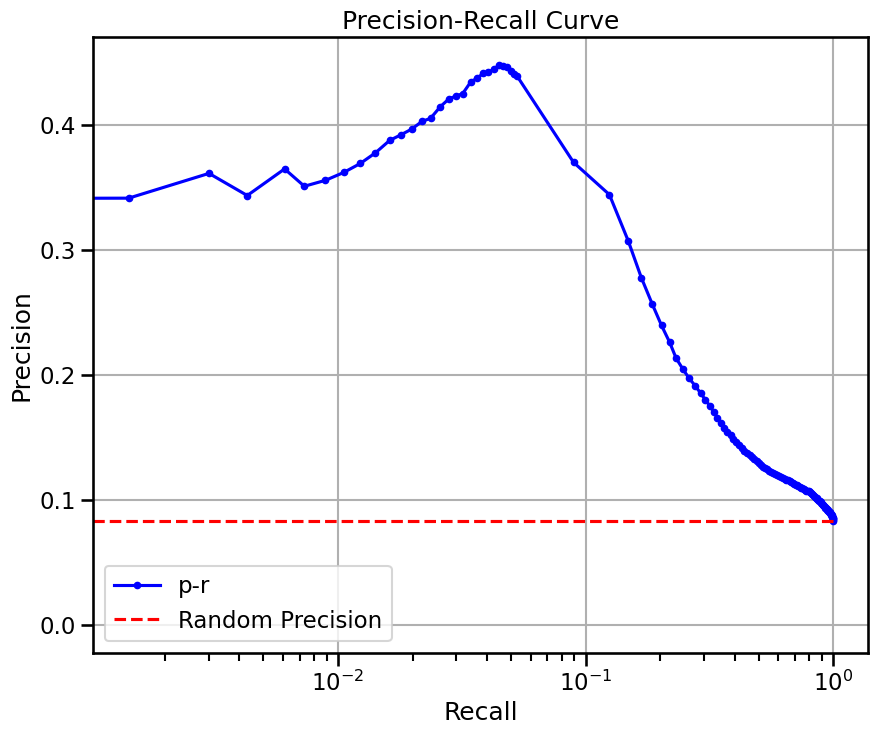

In [22]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_self_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [23]:
del grn

# mine / human

In [24]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers: 

KeysView(Layers with keys: )

checking raw counts

Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess

removed 0 non primary cells, 115 renamining

filtered out 0 cells, 115 renamining

Removed 0 genes.

startin QC

Seeing 105 outliers (91.30% of total dataset):

done

(GRnnData object with n_obs × n_vars = 115 × 28466
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11563 elements,
 35)

In [25]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 23516

/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [26]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision: 

0.026989275784456507


recall: 

1.0


random precision:

0.02699553054130111


  0%|                         | 0/128 [00:00<?, ?it/s]


 82%|██████████▋  | 105/128 [00:00<00:00, 1048.65it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|█████████████| 128/128 [00:00<00:00, 1087.19it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.024057408186047947

EPR:

0.03444985629014893

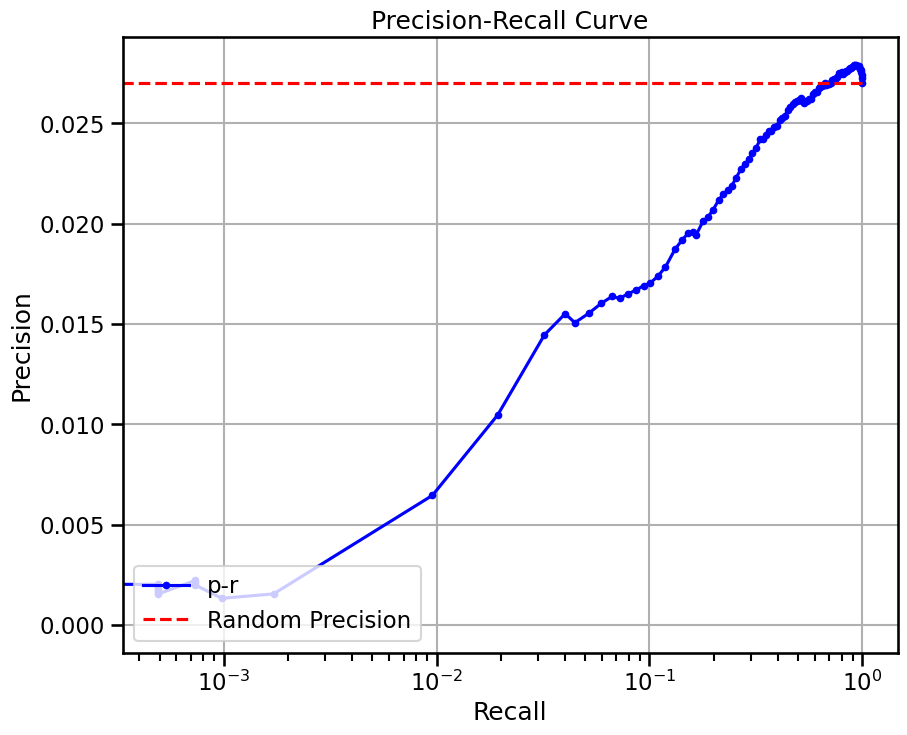

In [27]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment

Top central genes:

[]

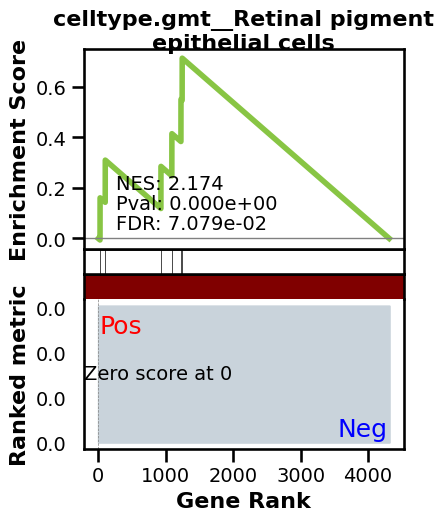

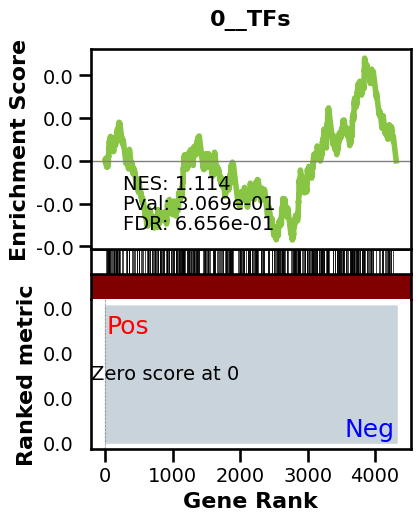

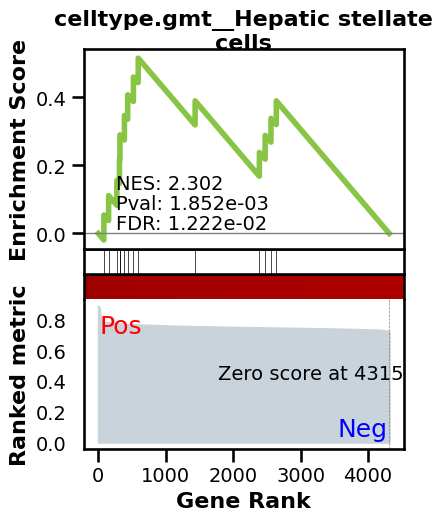

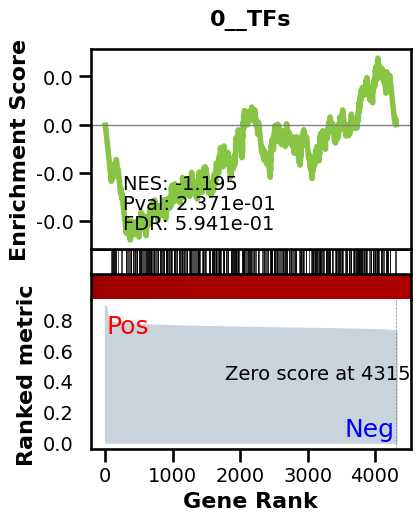

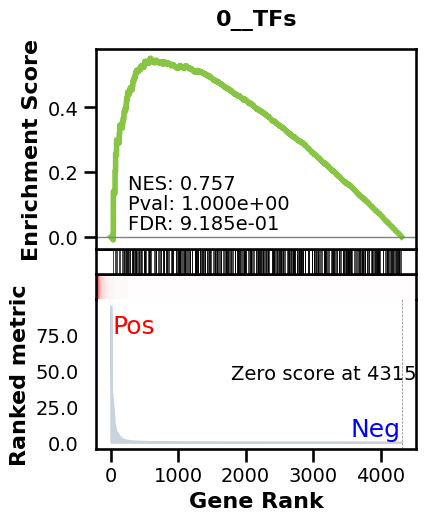

_________________________________________

TF specific enrichment

found some significant results for 

31.11111111111111

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 2840 genes

intersection pct:

0.6580166821130676

precision: 

0.0015955415592144415


recall: 

1.0


random precision:

0.0015961035675128615


  0%|                         | 0/128 [00:00<?, ?it/s]


  7%|█▏               | 9/128 [00:00<00:01, 82.59it/s]


 14%|██▎             | 18/128 [00:00<00:01, 83.43it/s]


 21%|███▍            | 27/128 [00:00<00:01, 83.00it/s]


 28%|████▌           | 36/128 [00:00<00:01, 83.27it/s]


 35%|█████▋          | 45/128 [00:00<00:00, 83.63it/s]


 42%|██████▊         | 54/128 [00:00<00:00, 83.84it/s]


 49%|███████▉        | 63/128 [00:00<00:00, 83.97it/s]


 56%|█████████       | 72/128 [00:00<00:00, 83.75it/s]


 63%|██████████▏     | 81/128 [00:00<00:00, 83.03it/s]


 70%|███████████▎    | 90/128 [00:01<00:00, 83.34it/s]


 77%|████████████▍   | 99/128 [00:01<00:00, 83.68it/s]


 84%|████████████▋  | 108/128 [00:01<00:00, 83.79it/s]


 91%|█████████████▋ | 117/128 [00:01<00:00, 84.00it/s]


 98%|██████████████▊| 126/128 [00:01<00:00, 83.61it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|███████████████| 128/128 [00:01<00:00, 83.40it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0018721386024757748

EPR:

1.8550678432580143

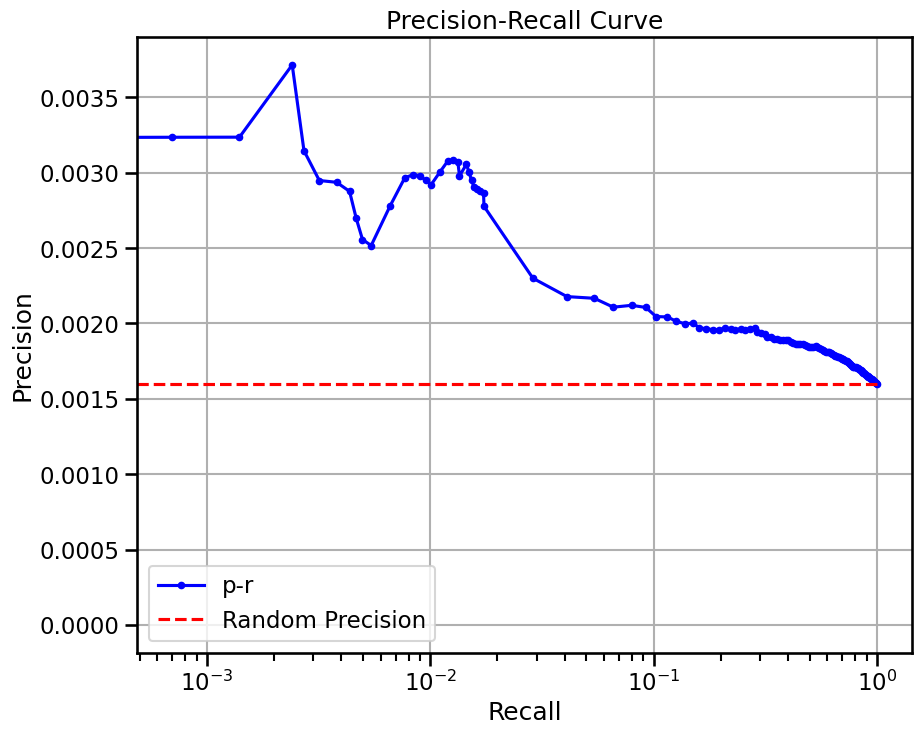

In [28]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision: 

0.026989275784456507


recall: 

1.0


random precision:

0.02699553054130111


  0%|                         | 0/128 [00:00<?, ?it/s]


 53%|███████▉       | 68/128 [00:00<00:00, 678.19it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 812.26it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.023631123115839876

EPR:

0.2529002269212142

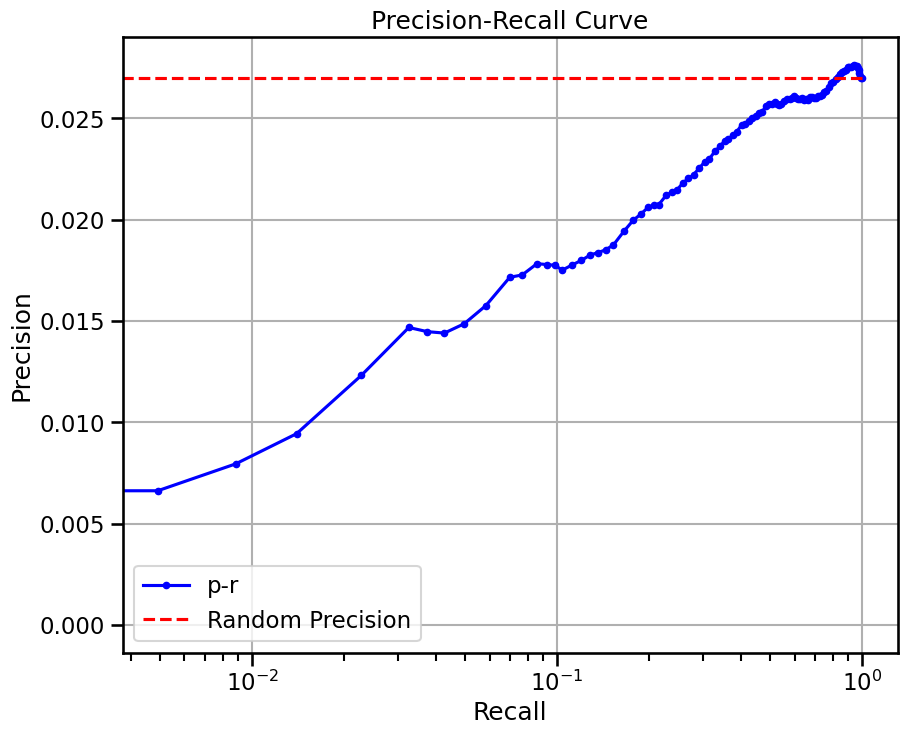

In [29]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment

Top central genes:

[]

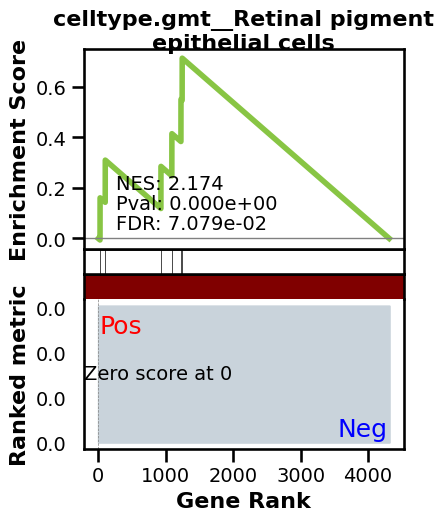

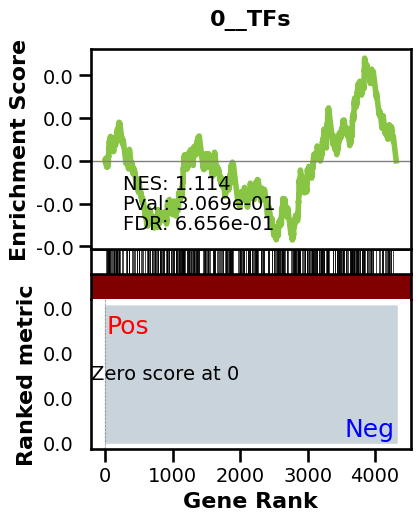

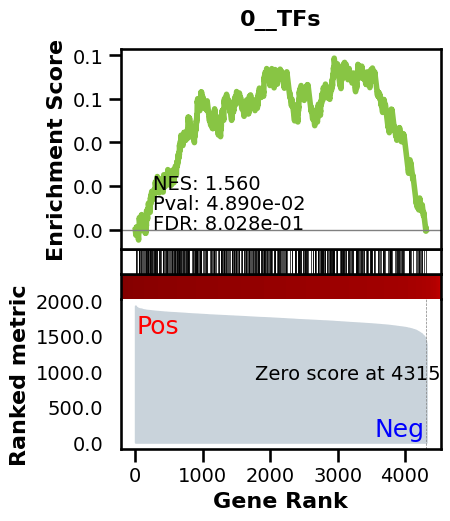

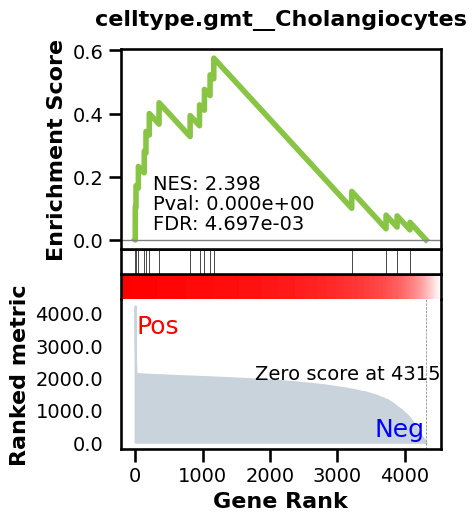

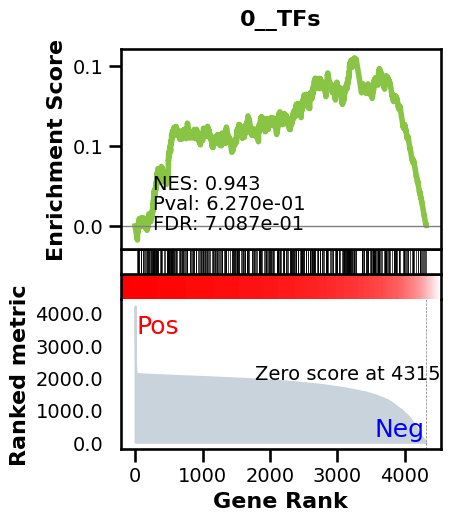

_________________________________________

TF specific enrichment

found some significant results for 

0.0

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 2840 genes

intersection pct:

0.6580166821130676

precision: 

0.0015955953682230903


recall: 

1.0


random precision:

0.0015961035675128615


  0%|                         | 0/128 [00:00<?, ?it/s]


  5%|▉                | 7/128 [00:00<00:01, 67.06it/s]


 11%|█▊              | 14/128 [00:00<00:01, 68.22it/s]


 16%|██▋             | 21/128 [00:00<00:01, 68.52it/s]


 23%|███▋            | 29/128 [00:00<00:01, 69.25it/s]


 28%|████▌           | 36/128 [00:00<00:01, 69.37it/s]


 34%|█████▌          | 44/128 [00:00<00:01, 69.67it/s]


 40%|██████▍         | 51/128 [00:00<00:01, 69.72it/s]


 45%|███████▎        | 58/128 [00:00<00:01, 69.73it/s]


 51%|████████▏       | 65/128 [00:00<00:00, 69.74it/s]


 56%|█████████       | 72/128 [00:01<00:00, 69.79it/s]


 62%|█████████▉      | 79/128 [00:01<00:00, 69.67it/s]


 67%|██████████▊     | 86/128 [00:01<00:00, 69.68it/s]


 73%|███████████▋    | 93/128 [00:01<00:00, 69.51it/s]


 78%|███████████▋   | 100/128 [00:01<00:00, 69.52it/s]


 84%|████████████▌  | 107/128 [00:01<00:00, 69.46it/s]


 89%|█████████████▎ | 114/128 [00:01<00:00, 69.07it/s]


 95%|██████████████▏| 121/128 [00:01<00:00, 68.73it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|███████████████| 128/128 [00:01<00:00, 67.79it/s]


100%|███████████████| 128/128 [00:01<00:00, 69.00it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0015272282233412325

EPR:

3.88137342810212

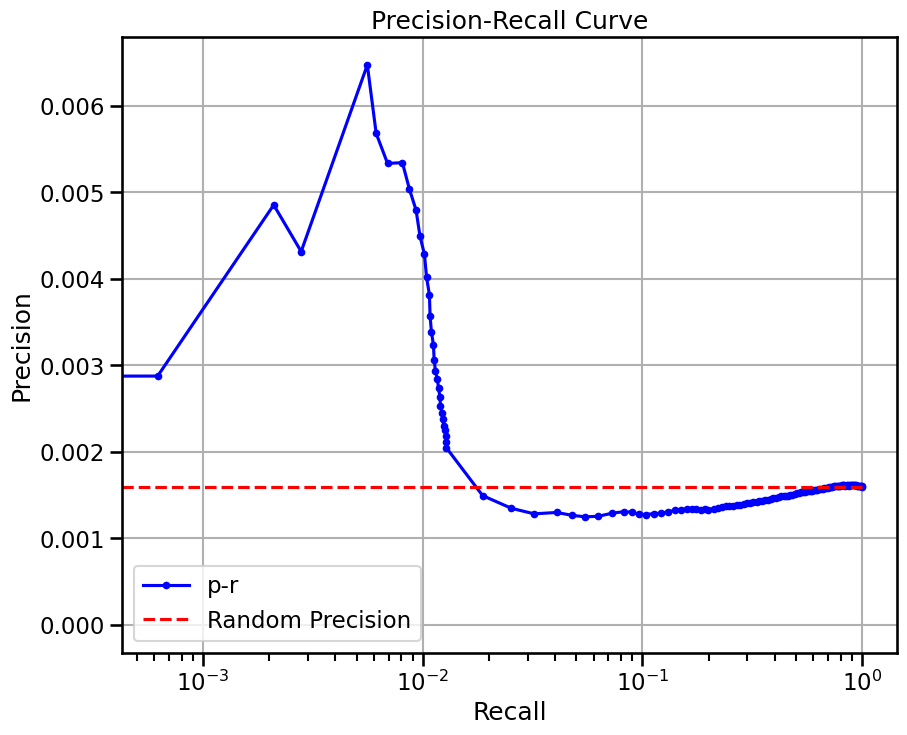

In [30]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['scprint_omni_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision: 

0.026989275784456507


recall: 

1.0


random precision:

0.02699553054130111


  0%|                         | 0/128 [00:00<?, ?it/s]


 66%|█████████▊     | 84/128 [00:00<00:00, 831.97it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 914.15it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.03720171835380524

EPR:

2.58783855686925

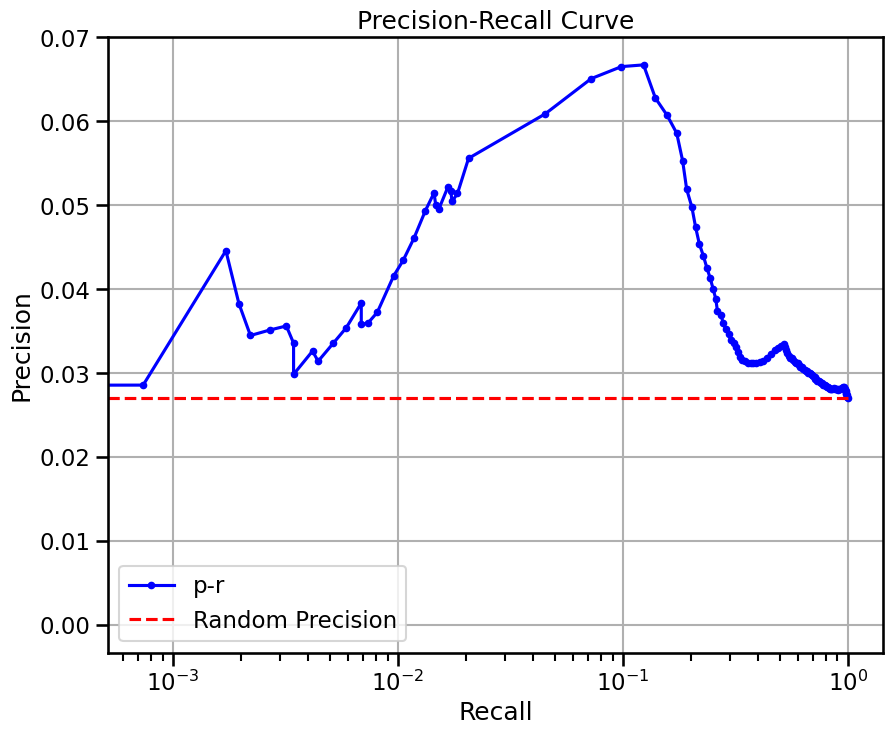

In [31]:
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment

Top central genes:

[]

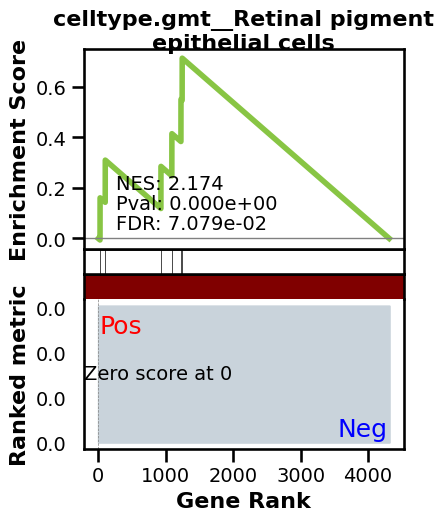

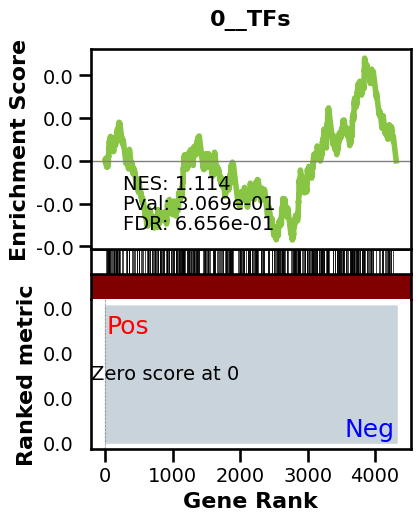

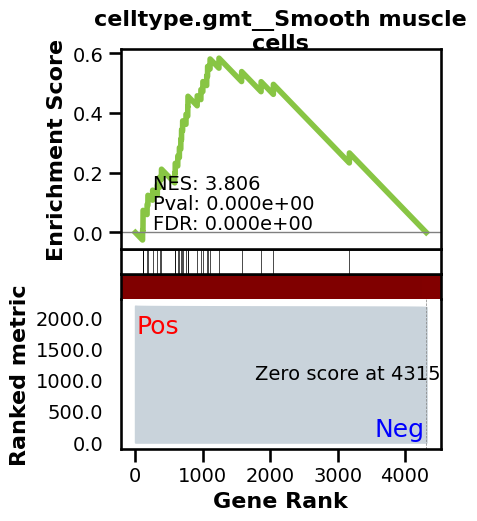

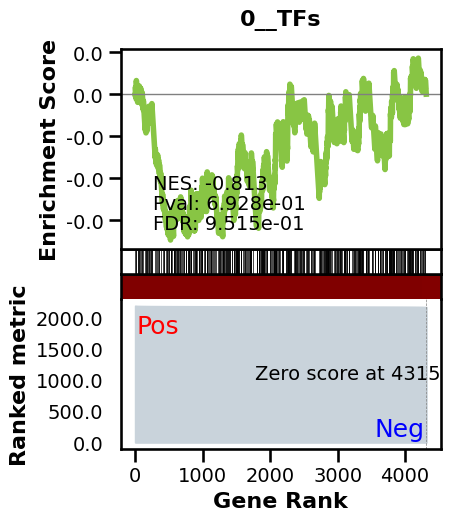

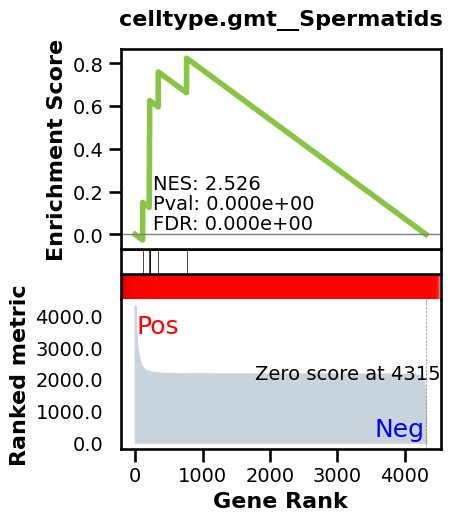

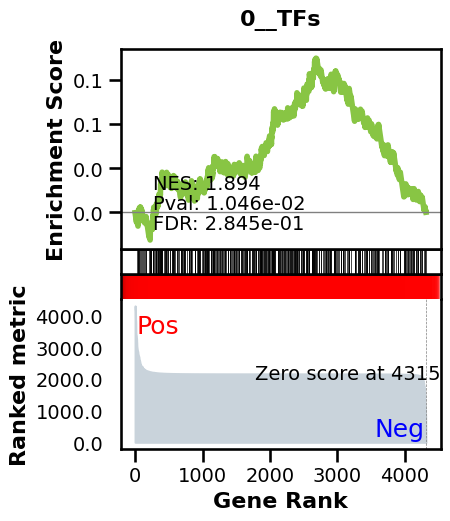

_________________________________________

TF specific enrichment

found some significant results for 

11.11111111111111

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 2840 genes

intersection pct:

0.6580166821130676

precision: 

0.0015955415592144415


recall: 

1.0


random precision:

0.0015961035675128615


  0%|                         | 0/128 [00:00<?, ?it/s]


  5%|▉                | 7/128 [00:00<00:01, 68.47it/s]


 11%|█▊              | 14/128 [00:00<00:01, 68.71it/s]


 16%|██▋             | 21/128 [00:00<00:01, 68.85it/s]


 22%|███▌            | 28/128 [00:00<00:01, 68.66it/s]


 27%|████▍           | 35/128 [00:00<00:01, 68.95it/s]


 33%|█████▎          | 42/128 [00:00<00:01, 69.09it/s]


 38%|██████▏         | 49/128 [00:00<00:01, 69.07it/s]


 44%|███████         | 56/128 [00:00<00:01, 69.04it/s]


 49%|███████▉        | 63/128 [00:00<00:00, 69.19it/s]


 55%|████████▊       | 70/128 [00:01<00:00, 69.29it/s]


 60%|█████████▋      | 77/128 [00:01<00:00, 69.40it/s]


 66%|██████████▌     | 84/128 [00:01<00:00, 68.55it/s]


 71%|███████████▍    | 91/128 [00:01<00:00, 68.58it/s]


 77%|████████████▎   | 98/128 [00:01<00:00, 68.71it/s]


 82%|████████████▎  | 105/128 [00:01<00:00, 68.99it/s]


 88%|█████████████▏ | 112/128 [00:01<00:00, 69.17it/s]


 93%|█████████████▉ | 119/128 [00:01<00:00, 69.25it/s]


 98%|██████████████▊| 126/128 [00:01<00:00, 64.94it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|███████████████| 128/128 [00:01<00:00, 68.06it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0015613117140317752

EPR:

0.5834421001227876

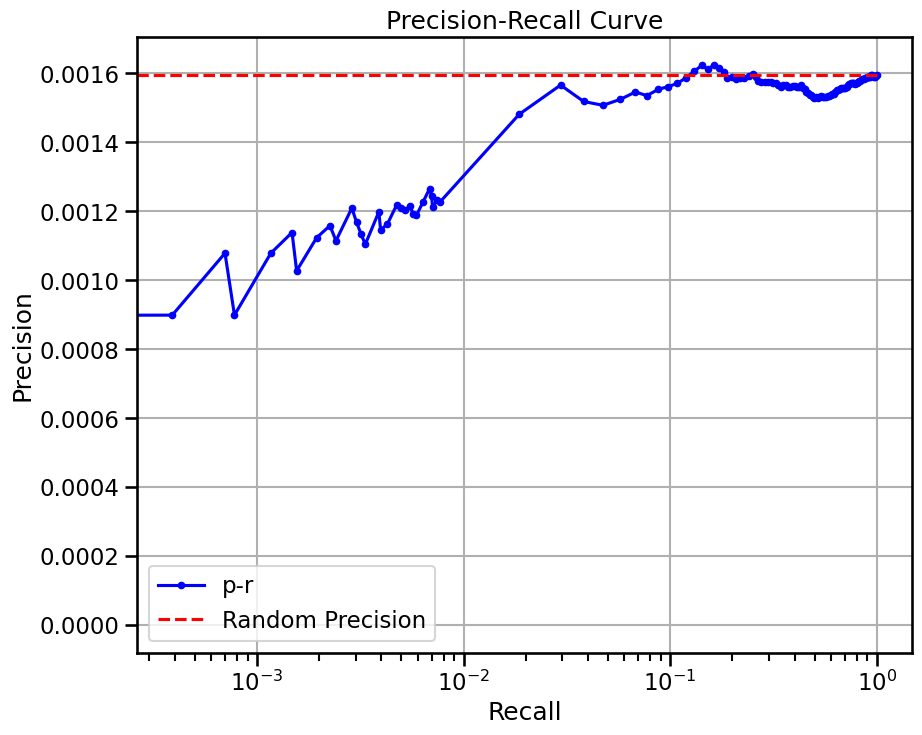

In [32]:
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_omni_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [33]:
del grn

In [34]:
metrics

{'scprint_mean_han_full': {'precision': 0.038948387096774194,
  'recall': 1.0,
  'rand_precision': 0.03895617833244068,
  'auprc': 0.0695345532881509,
  'epr': 2.978185129033612},
 'scprint_mean_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt

## tran / mouse

In [35]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers: 

KeysView(Layers with keys: )

checking raw counts

removed 0 non primary cells, 2369 renamining

filtered out 0 cells, 2369 renamining

Removed 0 genes.

startin QC

Seeing 91 outliers (3.84% of total dataset):

done

(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

In [36]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 6435

/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [37]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision: 

0.04014336917562724


recall: 

1.0


random precision:

0.04015140749544615


  0%|                         | 0/128 [00:00<?, ?it/s]


 62%|█████████▎     | 79/128 [00:00<00:00, 782.38it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 871.57it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.050669894408514785

EPR:

2.9838291137924227

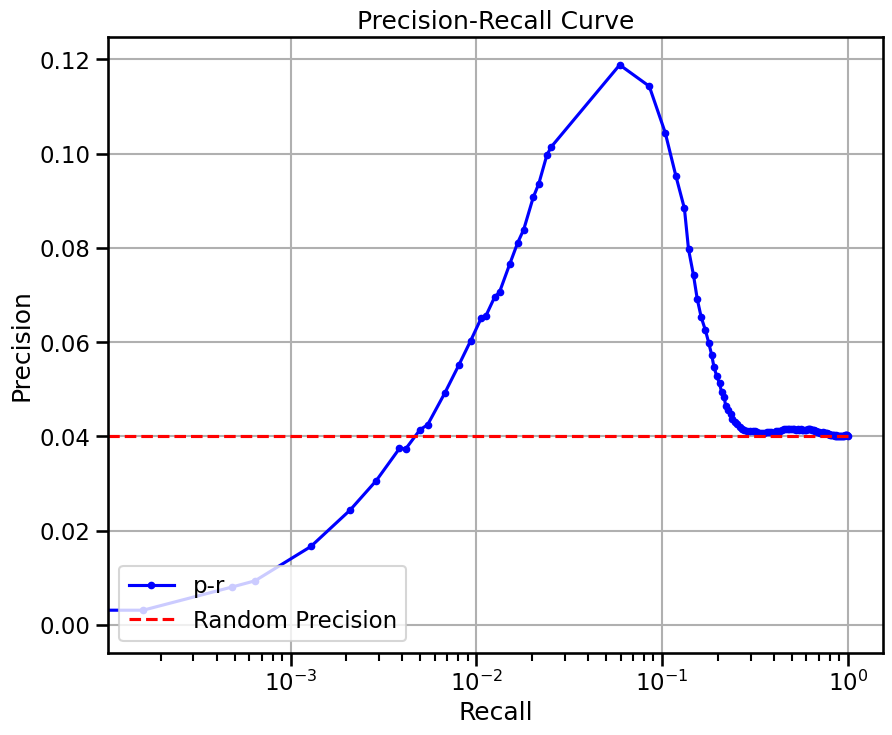

In [38]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.20101723344966588


recall: 

1.0


random precision:

0.20105748519845437


  0%|                         | 0/128 [00:00<?, ?it/s]


 29%|████▎          | 37/128 [00:00<00:00, 366.98it/s]


 84%|███████████▊  | 108/128 [00:00<00:00, 565.63it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 554.42it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.22212420599940003

EPR:

1.1545745762979105

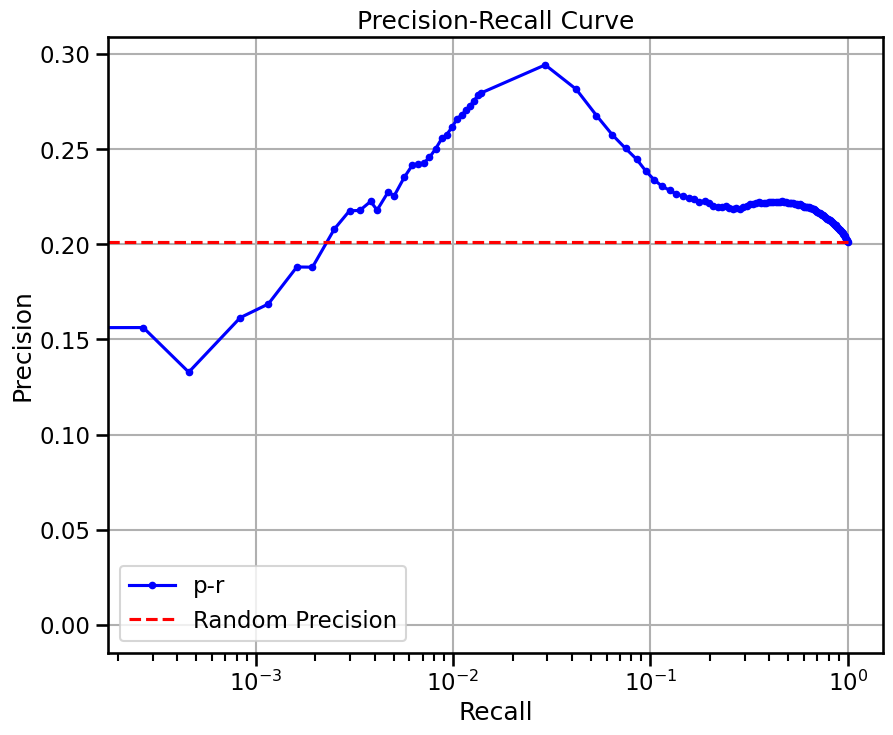

In [39]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_mean_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.0857875419278928


recall: 

1.0


random precision:

0.08580472005002494


  0%|                         | 0/128 [00:00<?, ?it/s]


 22%|███▎           | 28/128 [00:00<00:00, 279.88it/s]


 56%|████████▍      | 72/128 [00:00<00:00, 369.41it/s]


 91%|████████████▋ | 116/128 [00:00<00:00, 400.04it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 383.51it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.09120825494847014

EPR:

1.2424369659578294

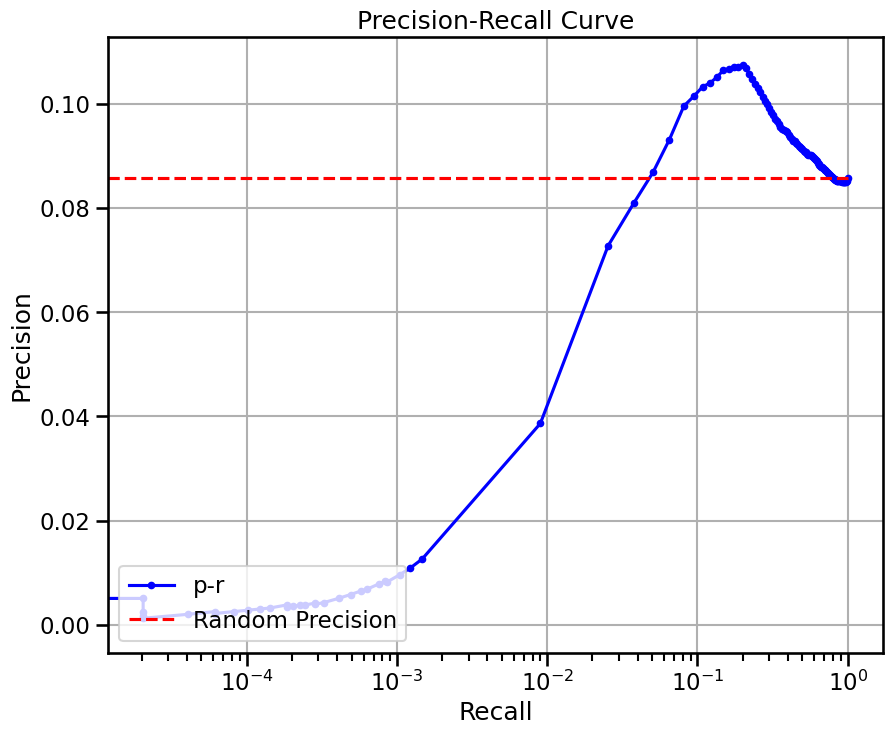

In [40]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_mean_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [41]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")

precision: 

0.04014336917562724


recall: 

1.0


random precision:

0.04015140749544615


  0%|                         | 0/128 [00:00<?, ?it/s]


 59%|████████▉      | 76/128 [00:00<00:00, 757.31it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 669.10it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.035071265721893424

EPR:

0.35342160541497697

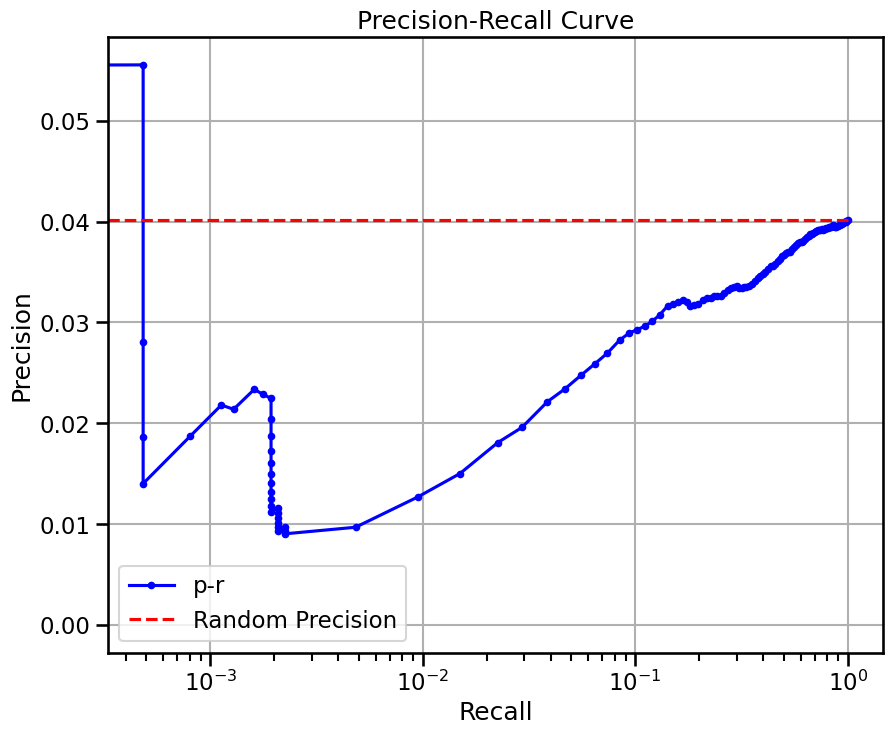

In [42]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.20101723344966588


recall: 

1.0


random precision:

0.20105748519845437


  0%|                         | 0/128 [00:00<?, ?it/s]


 43%|██████▍        | 55/128 [00:00<00:00, 548.93it/s]


 99%|█████████████▉| 127/128 [00:00<00:00, 648.90it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 625.67it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.17286163874275706

EPR:

0.6536411636393383

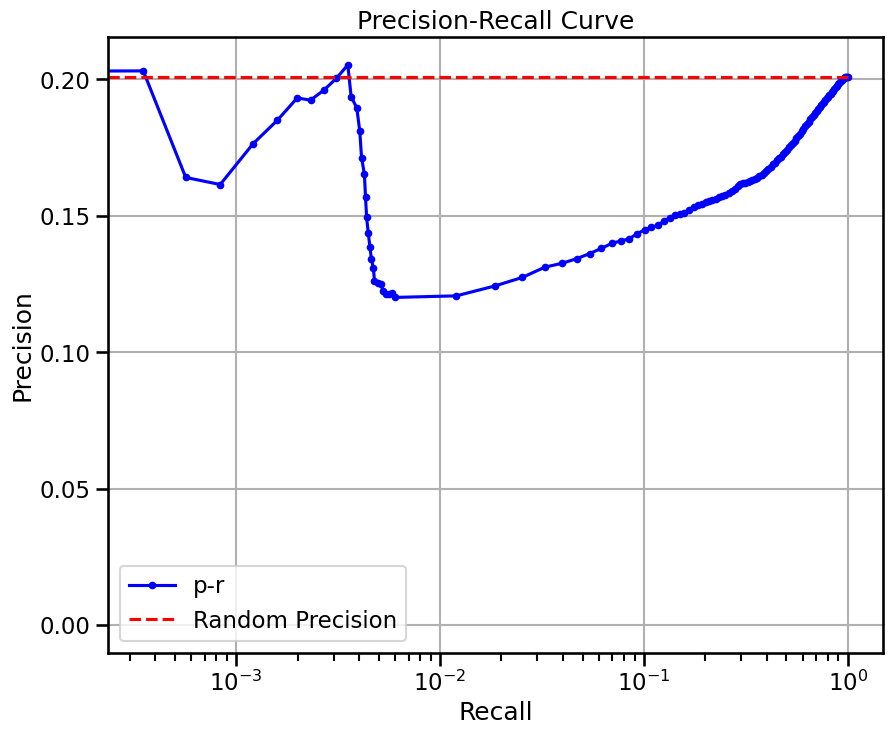

In [43]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_omni_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.0857875419278928


recall: 

1.0


random precision:

0.08580472005002494


  0%|                         | 0/128 [00:00<?, ?it/s]


 19%|██▊            | 24/128 [00:00<00:00, 239.84it/s]


 50%|███████▌       | 64/128 [00:00<00:00, 331.37it/s]


 83%|███████████▌  | 106/128 [00:00<00:00, 368.42it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 356.33it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.09214028608912822

EPR:

1.363780460855781

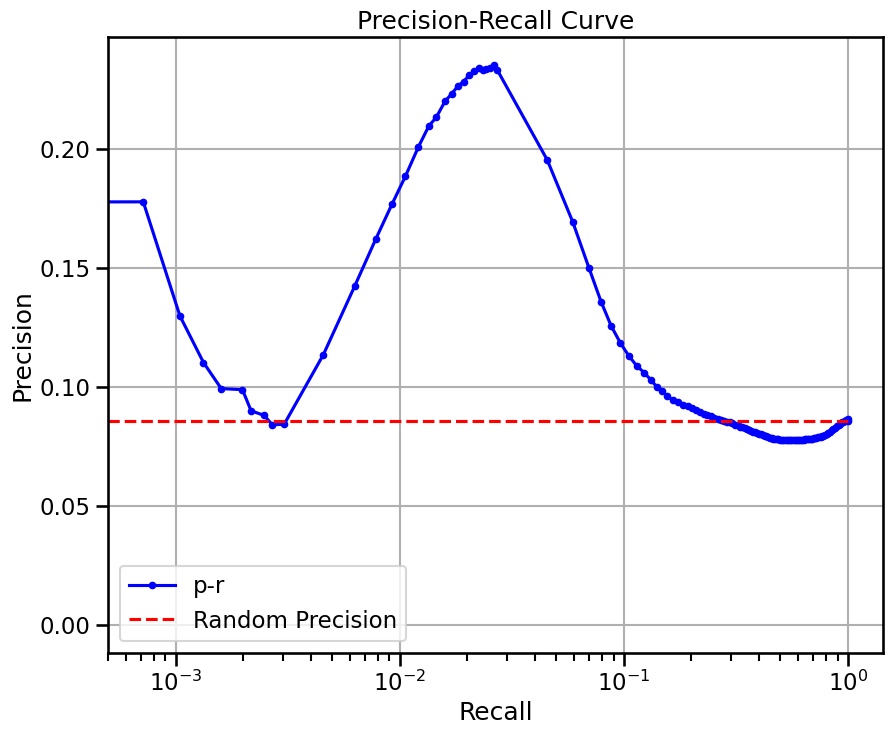

In [44]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_omni_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.04014336917562724


recall: 

1.0


random precision:

0.04015140749544615


  0%|                         | 0/128 [00:00<?, ?it/s]


 57%|████████▌      | 73/128 [00:00<00:00, 725.51it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 804.26it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.03207782258744176

EPR:

0.15314050058188136

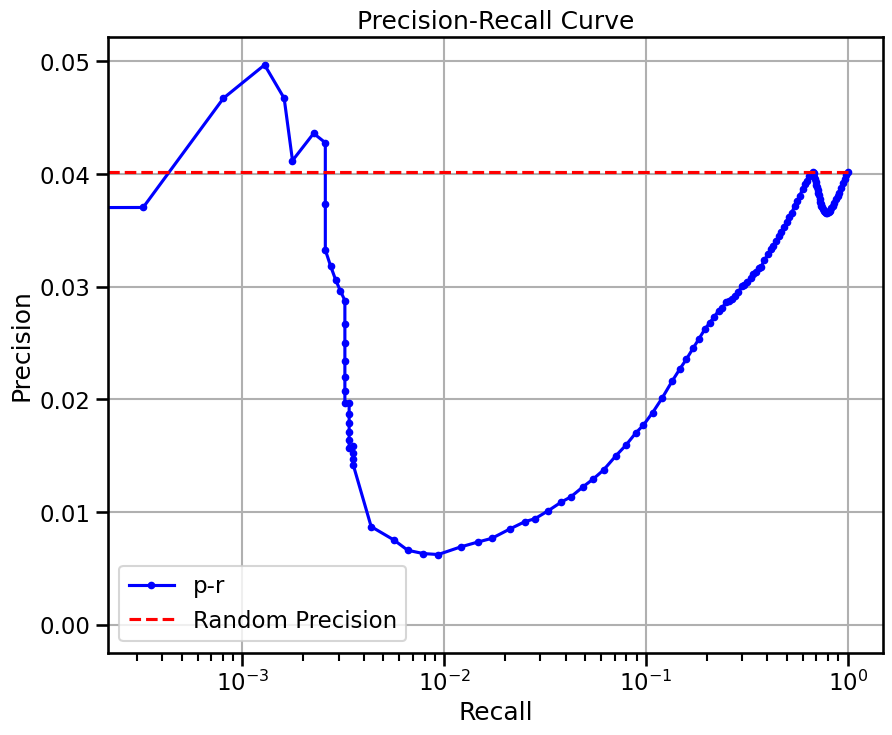

In [45]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.20101723344966588


recall: 

1.0


random precision:

0.20105748519845437


  0%|                         | 0/128 [00:00<?, ?it/s]


 40%|█████▉         | 51/128 [00:00<00:00, 508.87it/s]


 97%|█████████████▌| 124/128 [00:00<00:00, 636.90it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 610.24it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.21097213472259396

EPR:

1.167775692611248

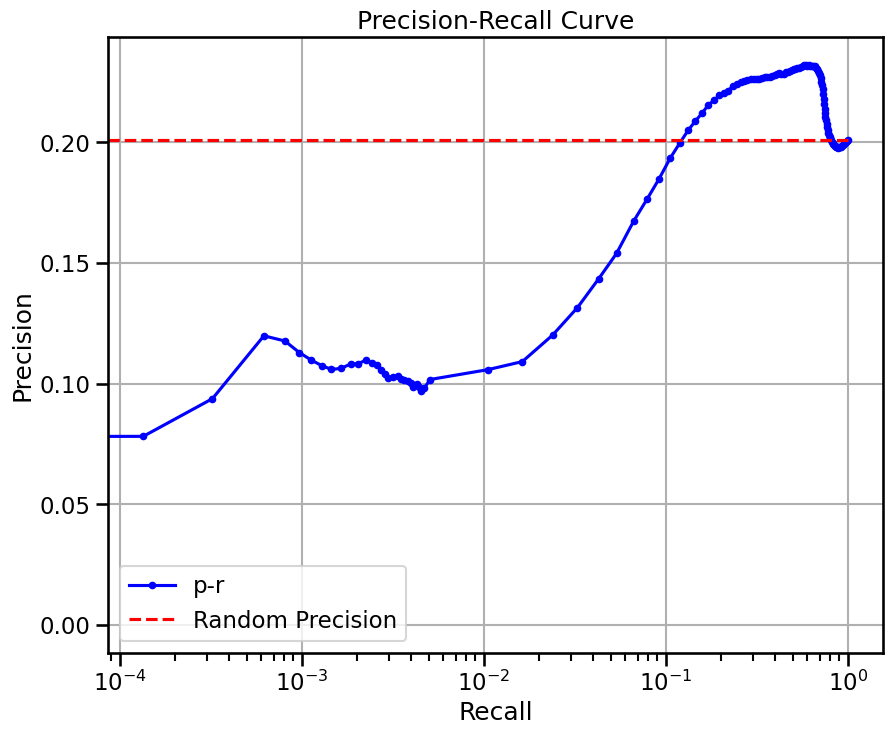

In [46]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_self_tranan_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.0857875419278928


recall: 

1.0


random precision:

0.08580472005002494


  0%|                         | 0/128 [00:00<?, ?it/s]


 27%|████           | 35/128 [00:00<00:00, 346.25it/s]


 59%|████████▊      | 75/128 [00:00<00:00, 375.96it/s]


 91%|████████████▊ | 117/128 [00:00<00:00, 394.70it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 384.84it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.08185549648134963

EPR:

0.5736779352103518

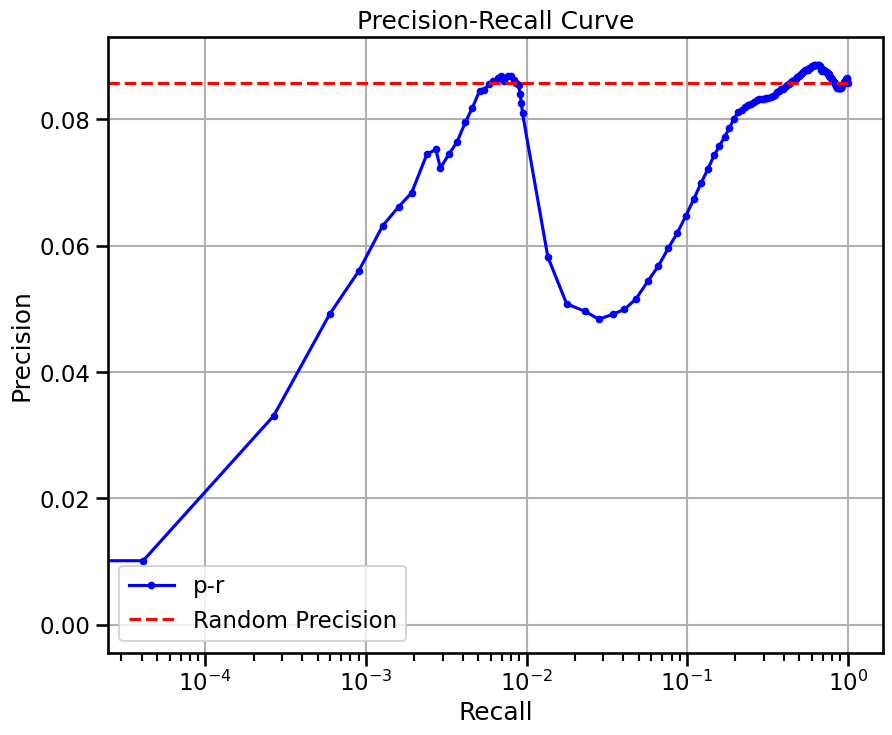

In [47]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_self_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [48]:
del grn

## zhao / mouse

In [49]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers: 

KeysView(Layers with keys: )

checking raw counts

removed 0 non primary cells, 36199 renamining

filtered out 0 cells, 36199 renamining

Removed 0 genes.

startin QC

Seeing 828 outliers (2.29% of total dataset):

done

(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

In [50]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8220

/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [51]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision: 

0.0392254862760778


recall: 

1.0


random precision:

0.03923332980462731


  0%|                         | 0/128 [00:00<?, ?it/s]


 54%|████████       | 69/128 [00:00<00:00, 682.29it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 789.76it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.04288757219675646

EPR:

0.24449026595628415

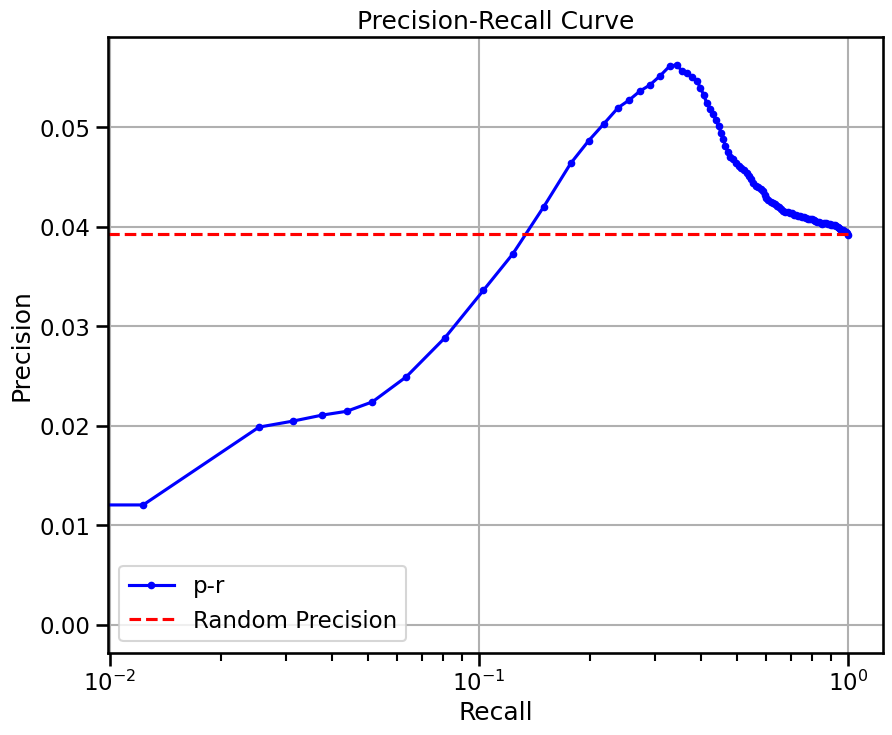

In [52]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.0392254862760778


recall: 

1.0


random precision:

0.03923332980462731


  0%|                         | 0/128 [00:00<?, ?it/s]


 49%|███████▍       | 63/128 [00:00<00:00, 622.14it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████████| 128/128 [00:00<00:00, 728.68it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.03470884109224168

EPR:

0.48413199324644557

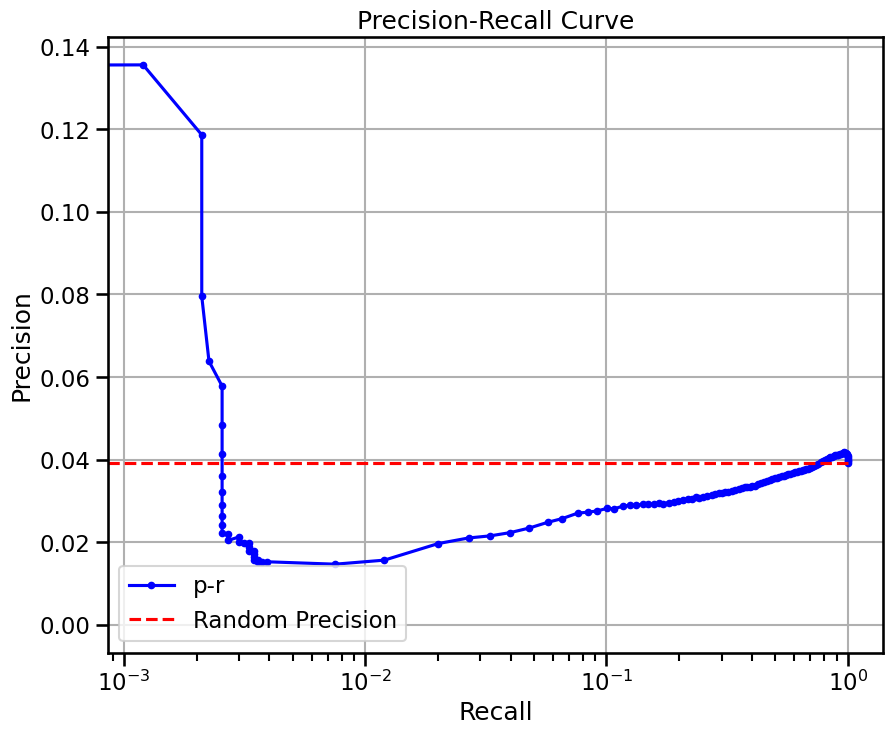

In [53]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.04670264983427216


recall: 

1.0


random precision:

0.046715764872136314


  0%|                       | 0/128 [00:00<?, ?it/s]


 73%|█████████▌   | 94/128 [00:00<00:00, 932.94it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|████████████| 128/128 [00:00<00:00, 960.34it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.037909203769457576

EPR:

0.087347440749958

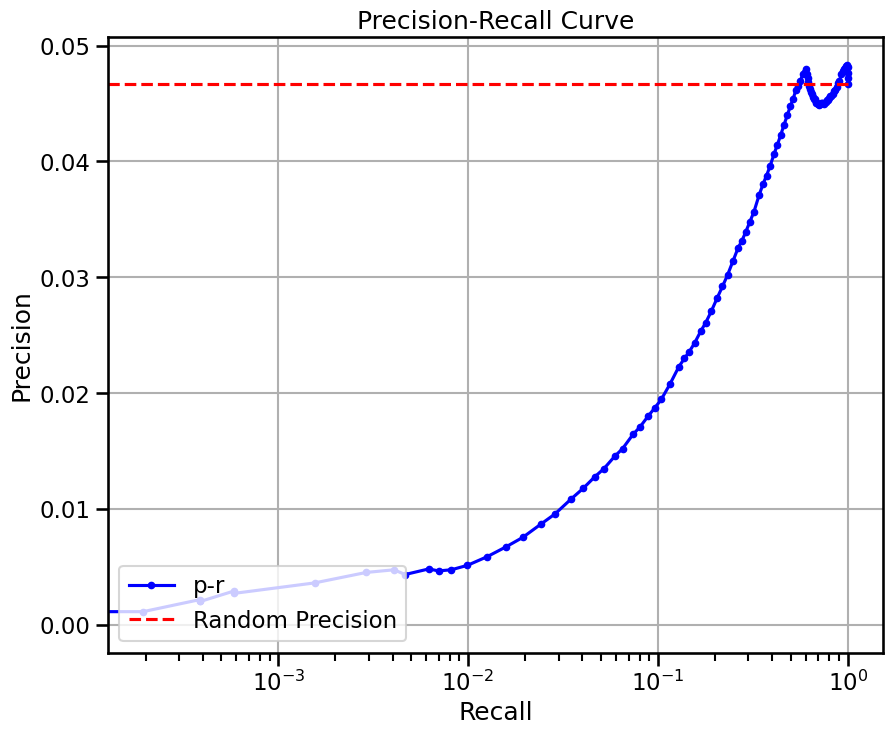

In [54]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [2]:
metrics

SyntaxError: unterminated string literal (detected at line 65) (3372979500.py, line 65)